In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
yhat = np.load(r"D:\fujiwara\KGAT-pytorch-master\trained_model\KGAT\last-fm\embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain2\cf_scores.npy")

In [4]:
with open('d_user_item_2050epoch.pkl', 'rb') as f:
	d_user_item = pickle.load(f)

In [5]:
with open('d_user_item_mean_2050epoch.pkl', 'rb') as f:
	d_user_item_mean = pickle.load(f)

In [10]:
with open('user_items.pkl', 'rb') as f:
	user_items = pickle.load(f)

In [7]:
with open('user_average_ranks_2050epoch.pkl', 'rb') as f:
	user_average_ranks = pickle.load(f)

In [5]:
with open('item_embed_2050epoch.pkl', 'rb') as f:
	item_embed = pickle.load(f)

In [6]:
with open('user_embed_2050epoch.pkl', 'rb') as f:
	user_embed = pickle.load(f)

In [ ]:
with open('ranks_2050epoch.pkl', 'rb') as f:
    ranks = pickle.load(f)

# ユーザごとにpitildeの平均値を求める

In [29]:
pi_tilde = torch.load(r"D:\fujiwara\KGAT-pytorch-master\pi_tilde_2050epoch.pth")
pi_tilde

tensor(indices=tensor([[ 12700,  18104,  23068,  ...,  48110,  19574,  12415],
                       [ 48123,  48123,  48123,  ..., 129954, 129954, 129954]]),
       values=tensor([ 7.7725,  8.0801,  7.7285,  ..., 13.1761, 12.8089,
                      12.9354]),
       size=(129955, 129955), nnz=3507140, layout=torch.sparse_coo)

In [30]:
A_in = pi_tilde.coalesce()
A_in

tensor(indices=tensor([[     0,      0,      0,  ..., 129954, 129954, 129954],
                       [ 48123,  51402,  73455,  ...,  29354,  47517,  48110]]),
       values=tensor([7.7261, 7.5116, 6.7313,  ..., 6.5542, 6.9807, 6.1662]),
       size=(129955, 129955), nnz=3472023, layout=torch.sparse_coo)

In [31]:
d = {}
for i in range(A_in.values().size(0)):
    d[A_in.indices()[0][i].item(), A_in.indices()[1][i].item()] = A_in.values()[i].item()

In [32]:
# 元の辞書 d
# 新しい辞書を初期化
d_user_item = {}

# d のキーとバリューを反復処理
for (id1, id2), value in d.items():
    # id1 がユーザID範囲内、かつ id2 がアイテムID範囲内の場合に処理
    if 106389 <= id1 <= 129954 and 0 <= id2 <= 48122:
        # 変換されたユーザIDとアイテムIDのペアをキーとしてバリューを格納
        d_user_item[id1 - 106389, id2] = value

d_user_item[0,0]

5.757107734680176

In [34]:
with open('d_user_item_2050epoch.pkl', 'wb') as f:
    pickle.dump(d_user_item, f)

In [ ]:
with open('d_user_item_2050epoch.pkl', 'rb') as f:
	d_user_item = pickle.load(f)

In [42]:
from collections import defaultdict

# Initializing a dictionary to store the total scores and counts for each user
user_scores = defaultdict(lambda: {'total': 0, 'count': 0})

# Summing up the scores and counts for each user
for (user_id, _), score in d_user_item.items():
    user_scores[user_id]['total'] += score
    user_scores[user_id]['count'] += 1

# Calculating the average score for each user
user_avg_scores = {user_id: scores['total'] / scores['count'] for user_id, scores in user_scores.items()}

# Displaying the first few entries to check
d_user_item_mean = dict(list(user_avg_scores.items()))

In [45]:
d_user_item_mean[23565]

6.425344058445522

In [46]:
with open('d_user_item_mean_2050epoch.pkl', 'wb') as f:
    pickle.dump(d_user_item_mean, f)

# rank aveを求める

In [9]:
user_items = {}
for (user_id, item_id), attention in tqdm(d_user_item.items()):
    if user_id not in user_items:
        user_items[user_id] = []
    user_items[user_id].append(item_id)

NameError: name 'd_user_item' is not defined

In [50]:
with open('user_items.pkl', 'wb') as f:
    pickle.dump(user_items, f)

In [62]:
yhat

array([[ 8.835761  ,  8.714614  , 13.879879  , ..., -5.3789315 ,
        -1.1665032 , -2.6803565 ],
       [ 6.6959014 ,  1.9621826 ,  2.807309  , ..., -5.2075458 ,
        -4.4759355 , -6.7108583 ],
       [-3.8745701 ,  2.2127137 ,  8.870994  , ..., -5.203553  ,
        -4.8945966 , -1.7176675 ],
       ...,
       [ 0.09775307,  3.9855335 ,  2.4739861 , ..., -0.46517938,
         0.94564515, -1.5951592 ],
       [-0.02715553, -0.73298264,  1.1908654 , ..., -2.7676766 ,
         0.20619774, -2.022019  ],
       [-2.7446485 , -7.213363  , -2.180703  , ..., -2.0791252 ,
        -5.602334  , -3.6029348 ]], dtype=float32)

In [11]:
# ranks_purchased = {}
user_average_ranks = {}


for user_id in tqdm(user_items):
    # 各アイテムに対する購入確率を取得
    probabilities = yhat[user_id]

    # 購入確率に基づいてアイテムをランキング（降順）
    ranked_items = np.argsort(probabilities)[::-1]
    
    # 過去に購入したアイテムのランキング順位を取得　順位が要素のリスト
    ranks_purchased = [np.where(ranked_items == item_id)[0][0] for item_id in user_items[user_id]]

    # ユーザーの購入アイテムの平均ランキング順位を計算
    user_average_ranks[user_id] = np.mean(ranks_purchased)

# user_average_ranks はユーザーIDをキーとし、その平均ランキング順位を値とする辞書

  0%|          | 0/23566 [00:00<?, ?it/s]

 16%|█▌        | 3698/23566 [00:19<01:45, 187.47it/s]


KeyboardInterrupt: 

In [11]:
ranks= {}
for user_id in tqdm(user_items):
    # 各アイテムに対する購入確率を取得
    probabilities = yhat[user_id]

    # 購入確率に基づいてアイテムをランキング（降順）
    ranked_items = np.argsort(probabilities)[::-1]

    # アイテムのランキングをリスト型で取得　index順位　要素アイテムID
    ranks[user_id] = list(ranked_items)

100%|██████████| 23566/23566 [01:35<00:00, 247.49it/s]


In [1]:
ranks[1][:10]

NameError: name 'ranks' is not defined

In [50]:
with open('ranks_purchased2050epoch.pkl', 'wb') as f:
    pickle.dump(ranks_purchased, f)

In [9]:
with open('ranks_2050epoch.pkl', 'wb') as f:
    pickle.dump(ranks, f)

In [54]:
user_average_ranks

{0: 131.23893805309734,
 1: 236.49484536082474,
 2: 135.12765957446808,
 3: 102.84883720930233,
 4: 138.6822429906542,
 5: 191.5,
 6: 600.65749235474,
 7: 182.45217391304348,
 8: 304.6771653543307,
 9: 20.36842105263158,
 10: 322.2875816993464,
 11: 3248.560276679842,
 12: 244.87985865724383,
 13: 4.222222222222222,
 14: 48.68421052631579,
 15: 44.80555555555556,
 16: 12.625,
 17: 1439.5374855824682,
 18: 315.16883116883116,
 19: 125.21739130434783,
 20: 299.5642201834862,
 21: 1072.1962365591398,
 22: 211.98936170212767,
 23: 31.9,
 24: 4.625,
 25: 331.403785488959,
 26: 37.092592592592595,
 27: 80.08,
 28: 219.36507936507937,
 29: 671.573275862069,
 30: 46.26829268292683,
 31: 314.752688172043,
 32: 1859.8092105263158,
 33: 72.41176470588235,
 34: 80.56410256410257,
 35: 40.74603174603175,
 36: 102.7,
 37: 390.5595238095238,
 38: 3.0,
 39: 680.4570135746607,
 40: 1009.762619372442,
 41: 27.37142857142857,
 42: 26.975,
 43: 39.073170731707314,
 44: 1127.2329896907218,
 45: 48.85714285

In [71]:
with open('user_average_ranks_2050epoch.pkl', 'wb') as f:
    pickle.dump(user_average_ranks, f)

In [56]:
d_user_item_mean.values()

dict_values([6.911968024431077, 6.0897605492896645, 6.805635016015235, 7.030753424001294, 6.202115745187919, 6.835564798322217, 6.483695386017499, 6.5771114224972935, 5.589556371133159, 7.861440056248715, 5.778007339028751, 3.8949950119487853, 7.117608917896823, 7.333354843987359, 7.738905605516936, 6.092115574412876, 6.178388029336929, 5.444881167791294, 5.451622219828816, 6.203787477120109, 5.880171580052157, 7.298599748521723, 5.618706272003498, 6.681641614437103, 7.118331432342529, 6.0395622794936505, 8.507195675814593, 6.517248983383179, 5.925979319072905, 5.024809521847758, 6.935866600129662, 6.315113361163806, 4.4431236705889825, 7.496218559788723, 6.721207484220847, 7.654254708971296, 5.78103084564209, 5.711387896821613, 8.536931242261614, 4.89240426391498, 4.713694612456214, 7.609337956564767, 7.508014142513275, 7.1898013556875835, 4.706142036693612, 6.997760704585484, 7.443863193194072, 7.1635943162636675, 7.008714252048069, 8.376999625453243, 7.251317277550697, 5.80652553275

In [57]:
list(d_user_item_mean.values())

[6.911968024431077,
 6.0897605492896645,
 6.805635016015235,
 7.030753424001294,
 6.202115745187919,
 6.835564798322217,
 6.483695386017499,
 6.5771114224972935,
 5.589556371133159,
 7.861440056248715,
 5.778007339028751,
 3.8949950119487853,
 7.117608917896823,
 7.333354843987359,
 7.738905605516936,
 6.092115574412876,
 6.178388029336929,
 5.444881167791294,
 5.451622219828816,
 6.203787477120109,
 5.880171580052157,
 7.298599748521723,
 5.618706272003498,
 6.681641614437103,
 7.118331432342529,
 6.0395622794936505,
 8.507195675814593,
 6.517248983383179,
 5.925979319072905,
 5.024809521847758,
 6.935866600129662,
 6.315113361163806,
 4.4431236705889825,
 7.496218559788723,
 6.721207484220847,
 7.654254708971296,
 5.78103084564209,
 5.711387896821613,
 8.536931242261614,
 4.89240426391498,
 4.713694612456214,
 7.609337956564767,
 7.508014142513275,
 7.1898013556875835,
 4.706142036693612,
 6.997760704585484,
 7.443863193194072,
 7.1635943162636675,
 7.008714252048069,
 8.376999625453

In [58]:
list(user_average_ranks.values())

[131.23893805309734,
 236.49484536082474,
 135.12765957446808,
 102.84883720930233,
 138.6822429906542,
 191.5,
 600.65749235474,
 182.45217391304348,
 304.6771653543307,
 20.36842105263158,
 322.2875816993464,
 3248.560276679842,
 244.87985865724383,
 4.222222222222222,
 48.68421052631579,
 44.80555555555556,
 12.625,
 1439.5374855824682,
 315.16883116883116,
 125.21739130434783,
 299.5642201834862,
 1072.1962365591398,
 211.98936170212767,
 31.9,
 4.625,
 331.403785488959,
 37.092592592592595,
 80.08,
 219.36507936507937,
 671.573275862069,
 46.26829268292683,
 314.752688172043,
 1859.8092105263158,
 72.41176470588235,
 80.56410256410257,
 40.74603174603175,
 102.7,
 390.5595238095238,
 3.0,
 680.4570135746607,
 1009.762619372442,
 27.37142857142857,
 26.975,
 39.073170731707314,
 1127.2329896907218,
 48.857142857142854,
 27.291666666666668,
 45.131147540983605,
 12.11111111111111,
 26.48148148148148,
 37.0,
 331.463768115942,
 70.84536082474227,
 118.88571428571429,
 77.594594594594

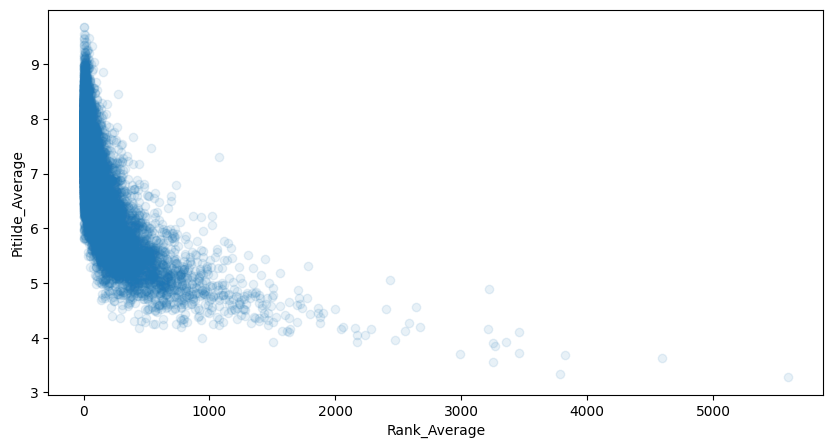

In [64]:
# 散布図に可視化
plt.figure(figsize=(10, 5))
plt.scatter(list(user_average_ranks.values()), list(d_user_item_mean.values()), alpha=0.1)
plt.xlabel('Rank_Average')
plt.ylabel('Pitilde_Average')
plt.show()

In [25]:
d_user_item_mean[5]

6.835564798322217

In [19]:
user_average_ranks[0]

131.23893805309734

In [26]:
import numpy as np

# Convert lists to numpy arrays for easier manipulation
attention_means_array = np.array(d_user_item_mean)
average_ranks_array = np.array(user_average_ranks)

# Identifying users in the bottom left corner of the plot (low average rank, high attention mean)
# Setting thresholds for "low" rank and "high" attention mean
rank_threshold = np.percentile(average_ranks_array, 25) # Lower 25% of ranks
attention_threshold = np.percentile(attention_means_array, 75) # Upper 25% of attention means

# Finding users that meet these criteria
selected_users = [user_id for user_id, (attention, rank) in enumerate(zip(attention_means_array, average_ranks_array))
                  if rank <= rank_threshold and attention >= attention_threshold]

selected_users[:10]  # Displaying first 10 user IDs that meet the criteria

TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [ ]:
left_bottom_users_manual = []
for user_id in range(len(attention_means_array)):
    if average_ranks_array[user_id] > left_threshold and 5 <= attention_means_array[user_id] <= 6:
        left_bottom_users_manual.append(user_id)
        if len(left_bottom_users_manual) >= 10:
            break  # Limiting to the first 10 users

# アイテムチェック

In [8]:
with open("entity_user_embed.weight_2050epoch.pkl", "rb") as f:
    entity_user_embed = pickle.load(f)

d:\fujiwara\KGAT-pytorch-master\.conda\lib\site-packages\torch\cuda\__init__.py:125: UserWarning: 
NVIDIA GeForce RTX 3070 Ti with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3070 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [11]:
entity_user_embed[129954]

tensor([ 0.9577,  0.3324,  0.6669, -0.5487,  1.1091,  0.2128,  0.8290, -0.8067,
         0.7120,  1.5418,  0.1052,  0.3095,  0.1706, -0.9751,  0.3720, -0.1114,
        -0.4842, -0.5081,  0.0030, -0.6120,  1.0713,  0.5716,  0.3148,  0.5240,
        -0.4129,  0.6747,  1.2317,  0.3062,  2.2501, -0.5569,  1.7419, -0.7212,
        -0.5593,  1.4456,  0.2101, -1.0399, -0.0824,  0.4381, -0.1764,  0.8435,
        -1.2736, -0.2198,  0.5207,  0.0963, -0.8135, -0.7027, -0.5317, -0.5604,
         0.2236, -1.0203, -1.4670,  0.4063,  0.4441, -0.0348,  0.2716, -1.2003,
        -0.3539,  0.8358,  0.2233, -0.0613, -0.2405, -0.4705,  1.0302, -1.4481],
       device='cuda:0')

In [86]:
with open('item_embed_2050epoch.pkl', 'rb') as f:
	item_embed = pickle.load(f)

In [15]:
user_embed = {}
for i in range(23566):
    user_embed[i] = entity_user_embed[i+106389].to('cpu')

In [17]:
user_embed[23565]

tensor([ 0.9577,  0.3324,  0.6669, -0.5487,  1.1091,  0.2128,  0.8290, -0.8067,
         0.7120,  1.5418,  0.1052,  0.3095,  0.1706, -0.9751,  0.3720, -0.1114,
        -0.4842, -0.5081,  0.0030, -0.6120,  1.0713,  0.5716,  0.3148,  0.5240,
        -0.4129,  0.6747,  1.2317,  0.3062,  2.2501, -0.5569,  1.7419, -0.7212,
        -0.5593,  1.4456,  0.2101, -1.0399, -0.0824,  0.4381, -0.1764,  0.8435,
        -1.2736, -0.2198,  0.5207,  0.0963, -0.8135, -0.7027, -0.5317, -0.5604,
         0.2236, -1.0203, -1.4670,  0.4063,  0.4441, -0.0348,  0.2716, -1.2003,
        -0.3539,  0.8358,  0.2233, -0.0613, -0.2405, -0.4705,  1.0302, -1.4481])

In [83]:
from sklearn.manifold import TSNE
# Function to compute Euclidean distance
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2)**2))

# Selected user ID for detailed analysis
# user_id = 11

def tsne_plot_for_user(user_id, user_embed, item_embed, user_items, N):
    # User vector
    user_vector = [user_embed[user_id].numpy()]

    # Purchased items
    purchased_items = user_items.get(user_id, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id][:N] if item_id in purchased_items]
    unpurchased_items_intopN = [item_id for item_id in ranks[user_id][:N] if item_id not in purchased_items]
    purchased_vectors_intopN = [item_embed[item_id].numpy() for item_id in purchased_items_intopN if item_id in item_embed]
    unpurchased_vectors_intopN = [item_embed[item_id].numpy() for item_id in unpurchased_items_intopN if item_id in item_embed]
    print("推薦数：{}".format(N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN)))
    # Combine user, purchased, and unpurchased item vectors
    user_vector = np.array(user_vector)
    purchased_vector = np.array(purchased_vectors_intopN)
    unpurchased_vector = np.array(unpurchased_vectors_intopN)
    all_vectors = np.concatenate([user_vector, purchased_vector, unpurchased_vector])
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    transformed_vectors = tsne.fit_transform(all_vectors)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot user
    transformed_user_vector = transformed_vectors[0, :]
    plt.scatter(transformed_user_vector[0], transformed_user_vector[1], c='red', label=f'User {user_id}')
    # plt.annotate(f'User {user_id}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot purchased items
    transformed_purchased_vectors = transformed_vectors[1:1+len(purchased_vector), :]
    plt.scatter(transformed_purchased_vectors[:, 0], transformed_purchased_vectors[:, 1], c='blue', marker='x', label=f'Items purchased by User {user_id}')
    

    # Plot unpurchased items
    transformed_unpurchased_vectors = transformed_vectors[len(purchased_vector)+1:, :]
    plt.scatter(transformed_unpurchased_vectors[:, 0], transformed_unpurchased_vectors[:, 1], c='green', marker='^',label=f'Unpurchased Items for User {user_id}')
    # plt.title(f"t-SNE Visualization for User {user_id}, Purchased and Unpurchased Items")
    plt.xlabel("t-SNE Feature 1")
    plt.ylabel("t-SNE Feature 2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# tsneを全てのユーザ、アイテムでやる

In [12]:
from sklearn.manifold import TSNE

all_user_embedding = np.array([user_embed[user_id].numpy() for user_id in user_embed])
all_item_embedding = np.array([item_embed[item_id].numpy() for item_id in item_embed])

temp_np = np.concatenate([all_user_embedding, all_item_embedding])

tsne = TSNE(n_components=2, random_state=0)

embeddings_2d = tsne.fit_transform(temp_np)

d:\fujiwara\KGAT-pytorch-master\.conda\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\fujiwara\KGAT-pytorch-master\.conda\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [13]:
embeddings_2d.shape

(71689, 2)

In [14]:
all_user_embedding_2d = embeddings_2d[:len(all_user_embedding), :]
all_item_embedding_2d = embeddings_2d[len(all_user_embedding):, :]

In [16]:
with open('all_user_embedding_2d_2050epoch.pkl','wb') as f:
    pickle.dump(all_user_embedding_2d, f)

In [17]:
with open('all_item_embedding_2d_2050epoch.pkl','wb') as f:
    pickle.dump(all_item_embedding_2d, f)

In [18]:
all_user_embedding_2d.shape

(23566, 2)

In [19]:
all_user_embedding_2d[23565]

array([ 33.178516, -24.6482  ], dtype=float32)

In [20]:
all_item_embedding_2d.shape

(48123, 2)

In [223]:
# 2人版の可視化
def tsne_plot_for_users(user_id_1, user_id_2, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    plt.figure(figsize=(12, 8))
    # Purchased items
    purchased_items = user_items.get(user_id_1, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_1][:N] if item_id in purchased_items]
    unpurchased_items_intopN_1 = [item_id for item_id in ranks[user_id_1][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    print("ユーザID{}の推薦数：{}".format(user_id_1, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_1)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_1][0], all_user_embedding_2d[user_id_1][1], c='red', label=f'User ID {user_id_1}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='red', marker='x', label=f'Items purchased by User ID {user_id_1}')

    # Purchased items
    purchased_items = user_items.get(user_id_2, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_2][:N] if item_id in purchased_items]
    unpurchased_items_intopN_2 = [item_id for item_id in ranks[user_id_2][:N] if item_id not in purchased_items]
    unpurchased_items_intopN_1.extend(unpurchased_items_intopN_2)
    list(set(unpurchased_items_intopN_1))
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN_1])

    print("ユーザID{}の推薦数：{}".format(user_id_2, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_2)))

    
    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_2][0], all_user_embedding_2d[user_id_2][1], c='blue', label=f'User ID {user_id_2}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='blue', marker='x', label=f'Items purchased by User ID {user_id_2}')

    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='green', marker='x',label=f'Unpurchased Items for User ID {user_id_1} and User ID {user_id_2}')
    
    # plt.title(f"t-SNE Visualization for User ID {user_id}, Purchased and Unpurchased Items")
    plt.xlabel("t-SNE Feature 1")
    plt.ylabel("t-SNE Feature 2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [71]:
# 2人版の可視化 ラベルと軸がないバージョン 色なし 白黒たいおう
def tsne_plot_for_users_notlabel(user_id_1, user_id_2, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    plt.figure(figsize=(12, 8))
    # Purchased items
    purchased_items = user_items.get(user_id_1, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_1][:N] if item_id in purchased_items]
    unpurchased_items_intopN_1 = [item_id for item_id in ranks[user_id_1][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    print("ユーザID{}の推薦数：{}".format(user_id_1, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_1)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_1][0], all_user_embedding_2d[user_id_1][1], c='white', edgecolor='k', marker='o', s=70, label=f'User ID {user_id_1}')
    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='k', marker='o', s=70, label=f'Items purchased by User ID {user_id_1}')

    # Purchased items
    purchased_items = user_items.get(user_id_2, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_2][:N] if item_id in purchased_items]
    unpurchased_items_intopN_2 = [item_id for item_id in ranks[user_id_2][:N] if item_id not in purchased_items]
    unpurchased_items_intopN_1.extend(unpurchased_items_intopN_2)
    list(set(unpurchased_items_intopN_1))
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN_1])

    print("ユーザID{}の推薦数：{}".format(user_id_2, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_2)))

    
    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_2][0], all_user_embedding_2d[user_id_2][1], c='white', edgecolor='k', marker='^', s=70, label=f'User ID {user_id_2}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1],  c='k', marker='^', s=70, label=f'Items purchased by User ID {user_id_2}')

    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='k', marker='x', s=10, linewidths=0.5, label=f'Unpurchased Items for User ID {user_id_1} and User ID {user_id_2}')
    
    # plt.title(f"t-SNE Visualization for User ID {user_id}, Purchased and Unpurchased Items")
    # plt.xlabel("t-SNE Feature 1")
    # plt.ylabel("t-SNE Feature 2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [92]:
# 2人版の可視化 ラベルと軸がないバージョン 色なし 白黒たいおう
def tsne_plot_for_users_label(user_id_1, user_id_2, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    plt.figure(figsize=(12, 8))
    # Purchased items
    purchased_items = user_items.get(user_id_1, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_1][:N] if item_id in purchased_items]
    unpurchased_items_intopN_1 = [item_id for item_id in ranks[user_id_1][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    print("ユーザID{}の推薦数：{}".format(user_id_1, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_1)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_1][0], all_user_embedding_2d[user_id_1][1], c='k', marker='o', s=70, label=f'User ID {user_id_1}')
    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='white', edgecolor='k', marker='o', s=70, label=f'Items purchased by User ID {user_id_1}')

    # Purchased items
    purchased_items = user_items.get(user_id_2, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_2][:N] if item_id in purchased_items]
    unpurchased_items_intopN_2 = [item_id for item_id in ranks[user_id_2][:N] if item_id not in purchased_items]
    unpurchased_items_intopN_1.extend(unpurchased_items_intopN_2)
    list(set(unpurchased_items_intopN_1))
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN_1])

    print("ユーザID{}の推薦数：{}".format(user_id_2, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_2)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_2][0], all_user_embedding_2d[user_id_2][1], c='k', marker='^', s=70, label=f'User ID {user_id_2}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='white', edgecolor='k', marker='^', s=70, label=f'Items purchased by User ID {user_id_2}')
    
    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='k', marker='x', s=10, linewidths=0.5, label=f'Unpurchased Items for User ID {user_id_1} and User ID {user_id_2}')

    # plt.title(f"t-SNE Visualization for User ID {user_id}, Purchased and Unpurchased Items")
    # plt.xlabel("t-SNE Feature 1")
    # plt.ylabel("t-SNE Feature 2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [122]:
# 一人版の可視化 これで行く
def tsne_plot_for_user(user_id, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    
    # Purchased items
    purchased_items = user_items.get(user_id, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id][:N] if item_id in purchased_items]
    unpurchased_items_intopN = [item_id for item_id in ranks[user_id][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN])
    print("推薦数：{}".format(N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN)))
    
    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id][0], all_user_embedding_2d[user_id][1], c='k', marker='o', label=f'User ID {user_id}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='k', marker='x', label=f'Items purchased by User ID {user_id}')

    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='k', marker='^',label=f'Unpurchased Items for User ID {user_id}')
    
    # plt.title(f"t-SNE Visualization for User ID{user_id}, Purchased and Unpurchased Items")
    # plt.xlabel("t-SNE Feature 1")
    # plt.ylabel("t-SNE Feature 2")
    plt.xlim(-60, 75)
    plt.ylim(-75, 40)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [121]:
# 2人版の可視化 ラベルがない  白黒たいおう　これでいく
def tsne_plot_for_users_notlabel(user_id_1, user_id_2, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    plt.figure(figsize=(12, 8))
    # Purchased items
    purchased_items = user_items.get(user_id_1, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_1][:N] if item_id in purchased_items]
    unpurchased_items_intopN_1 = [item_id for item_id in ranks[user_id_1][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    print("ユーザID{}の推薦数：{}".format(user_id_1, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_1)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_1][0], all_user_embedding_2d[user_id_1][1], c='white', edgecolor='k', marker='o', s=70, label=f'User ID {user_id_1}')
    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='k', marker='o', s=70, alpha=0.5, label=f'Items purchased by User ID {user_id_1}')

    # Purchased items
    purchased_items = user_items.get(user_id_2, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_2][:N] if item_id in purchased_items]
    unpurchased_items_intopN_2 = [item_id for item_id in ranks[user_id_2][:N] if item_id not in purchased_items]
    unpurchased_items_intopN_1.extend(unpurchased_items_intopN_2)
    list(set(unpurchased_items_intopN_1))
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN_1])

    print("ユーザID{}の推薦数：{}".format(user_id_2, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_2)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_2][0], all_user_embedding_2d[user_id_2][1], c='white', edgecolor='k', marker='^', s=70, label=f'User ID {user_id_2}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1], c='k', marker='^', s=70, alpha=0.5, label=f'Items purchased by User ID {user_id_2}')
    
    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='k', marker='x', s=10, linewidths=0.5, label=f'Unpurchased Items for User ID {user_id_1} and User ID {user_id_2}')

    # plt.title(f"t-SNE Visualization for User ID {user_id}, Purchased and Unpurchased Items")
    # plt.xlabel("t-SNE Feature 1")
    # plt.ylabel("t-SNE Feature 2")
    # plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [117]:
# 2人版の可視化 ラベルがある  白黒たいおう これで行く
def tsne_plot_for_users_label(user_id_1, user_id_2, all_user_embedding_2d, all_item_embedding_2d, user_items, N):
    plt.figure(figsize=(12, 8))
    # Purchased items
    purchased_items = user_items.get(user_id_1, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_1][:N] if item_id in purchased_items]
    unpurchased_items_intopN_1 = [item_id for item_id in ranks[user_id_1][:N] if item_id not in purchased_items]
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    print("ユーザID{}の推薦数：{}".format(user_id_1, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_1)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_1][0], all_user_embedding_2d[user_id_1][1], c='white', edgecolor='k', marker='o', s=70, label=f'User ID {user_id_1}')
    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1],  c='k', marker='o', s=70, alpha=0.5, label=f'Items purchased by User ID {user_id_1}')

    # Purchased items
    purchased_items = user_items.get(user_id_2, [])
    purchased_items_intopN = [item_id for item_id in ranks[user_id_2][:N] if item_id in purchased_items]
    unpurchased_items_intopN_2 = [item_id for item_id in ranks[user_id_2][:N] if item_id not in purchased_items]
    unpurchased_items_intopN_1.extend(unpurchased_items_intopN_2)
    list(set(unpurchased_items_intopN_1))
    purchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in purchased_items_intopN])
    unpurchased_vectors_intopN_2d = np.array([all_item_embedding_2d[item_id] for item_id in unpurchased_items_intopN_1])

    print("ユーザID{}の推薦数：{}".format(user_id_2, N))
    print("内、過去に購入したアイテム数：{}".format(len(purchased_items_intopN)))
    print("内、過去に購入していないアイテム数：{}".format(len(unpurchased_items_intopN_2)))

    # Plot user
    plt.scatter(all_user_embedding_2d[user_id_2][0], all_user_embedding_2d[user_id_2][1], c='white', edgecolor='k', marker='^', s=70, label=f'User ID {user_id_2}')

    # Plot purchased items
    plt.scatter(purchased_vectors_intopN_2d[:, 0], purchased_vectors_intopN_2d[:, 1] , c='k', marker='^', s=70, alpha=0.5 ,label=f'Items purchased by User ID {user_id_2}')
    
    # Plot unpurchased items
    plt.scatter(unpurchased_vectors_intopN_2d[:, 0], unpurchased_vectors_intopN_2d[:, 1], c='k', marker='x', s=10, linewidths=0.5, label=f'Unpurchased Items for User ID {user_id_1} and User ID {user_id_2}')

    # plt.title(f"t-SNE Visualization for User ID {user_id}, Purchased and Unpurchased Items")
    # plt.xlabel("t-SNE Feature 1")
    # plt.ylabel("t-SNE Feature 2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [182]:
N=100

ユーザID5015の推薦数：100
内、過去に購入したアイテム数：51
内、過去に購入していないアイテム数：49
ユーザID10608の推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


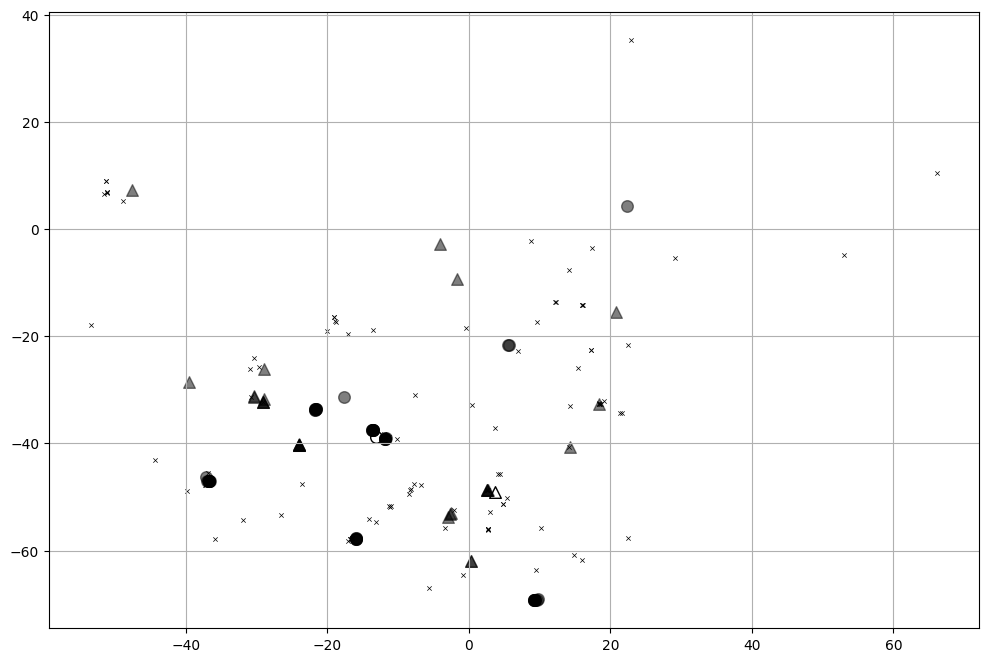

In [123]:
tsne_plot_for_users_notlabel(5015, 10608, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID5015の推薦数：100
内、過去に購入したアイテム数：51
内、過去に購入していないアイテム数：49
ユーザID10608の推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


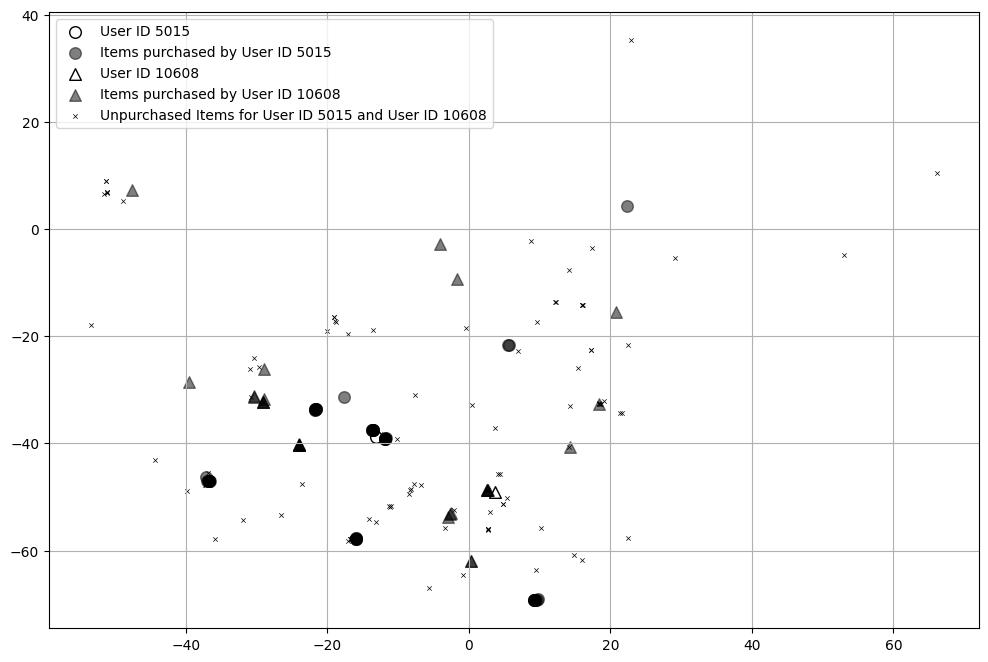

In [119]:
tsne_plot_for_users_label(5015, 10608, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID47の推薦数：100
内、過去に購入したアイテム数：55
内、過去に購入していないアイテム数：45
ユーザID237の推薦数：100
内、過去に購入したアイテム数：61
内、過去に購入していないアイテム数：39


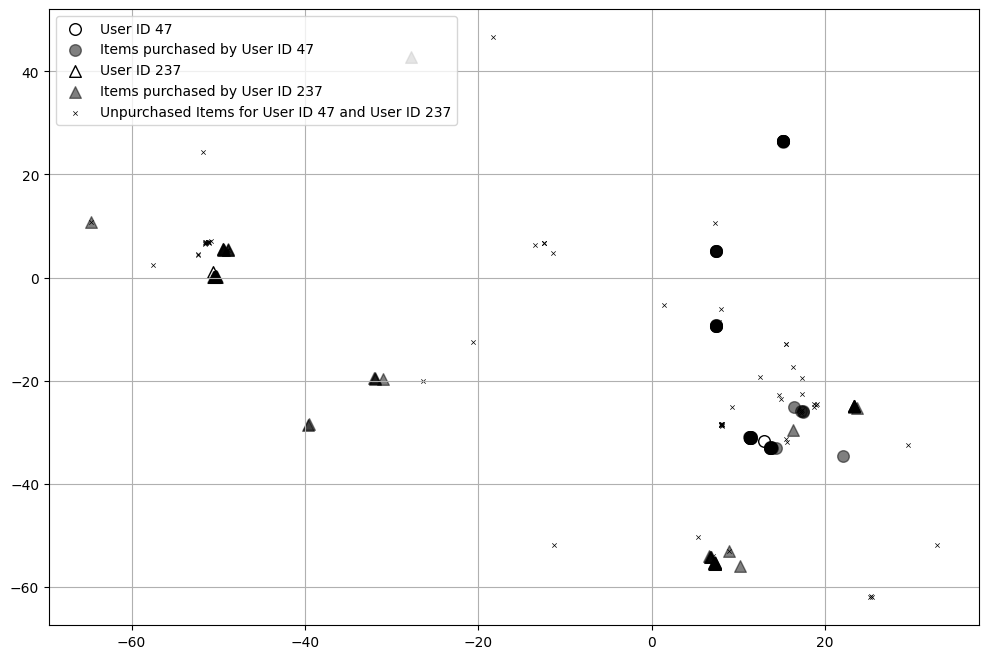

In [124]:
tsne_plot_for_users_label(47, 237, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID47の推薦数：100
内、過去に購入したアイテム数：55
内、過去に購入していないアイテム数：45
ユーザID237の推薦数：100
内、過去に購入したアイテム数：61
内、過去に購入していないアイテム数：39


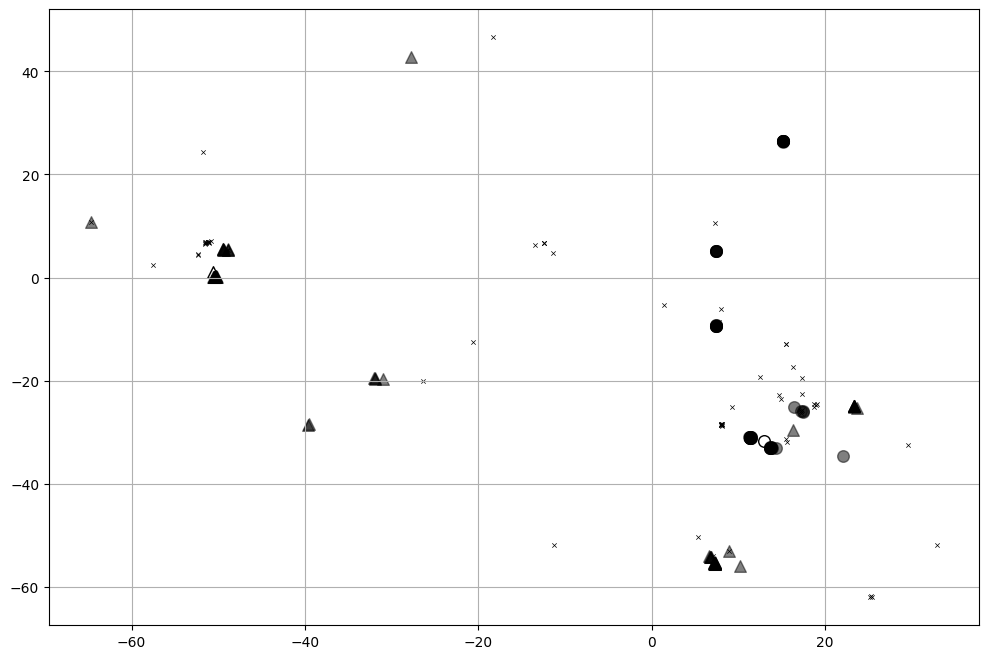

In [128]:
tsne_plot_for_users_notlabel(47, 237, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID47の推薦数：100
内、過去に購入したアイテム数：55
内、過去に購入していないアイテム数：45
ユーザID772の推薦数：100
内、過去に購入したアイテム数：26
内、過去に購入していないアイテム数：74


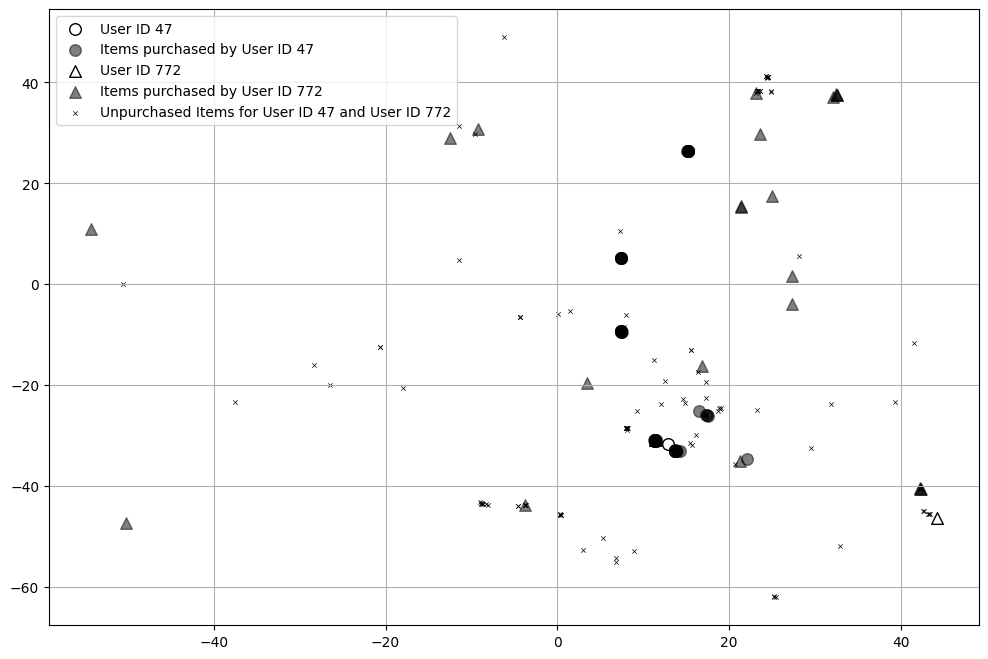

In [129]:
tsne_plot_for_users_label(47, 772, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID47の推薦数：100
内、過去に購入したアイテム数：55
内、過去に購入していないアイテム数：45
ユーザID772の推薦数：100
内、過去に購入したアイテム数：26
内、過去に購入していないアイテム数：74


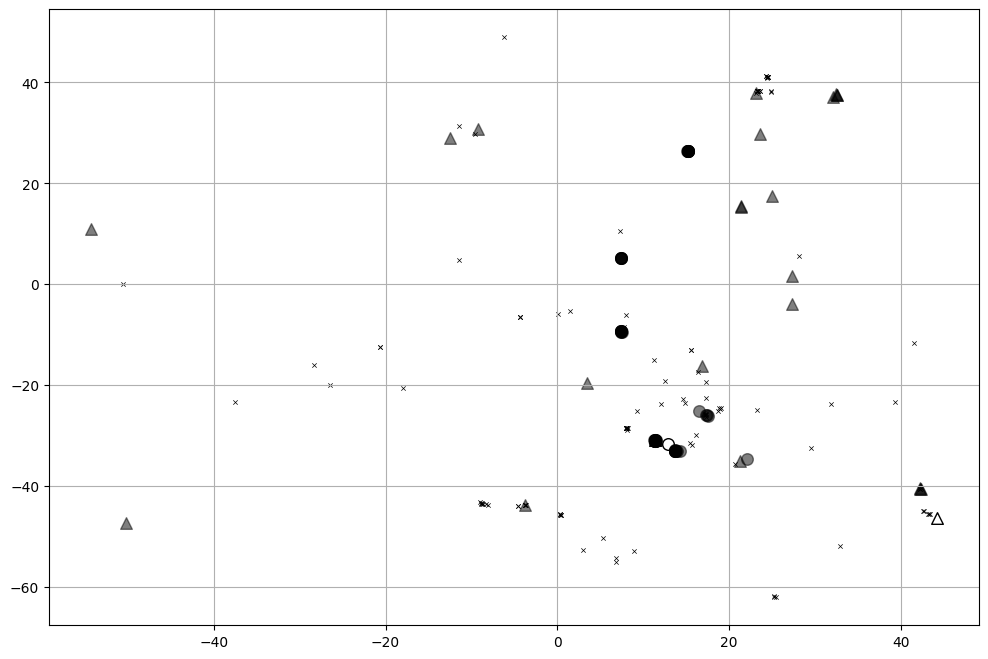

In [127]:
tsne_plot_for_users_notlabel(47, 772, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID204の推薦数：100
内、過去に購入したアイテム数：4
内、過去に購入していないアイテム数：96
ユーザID276の推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


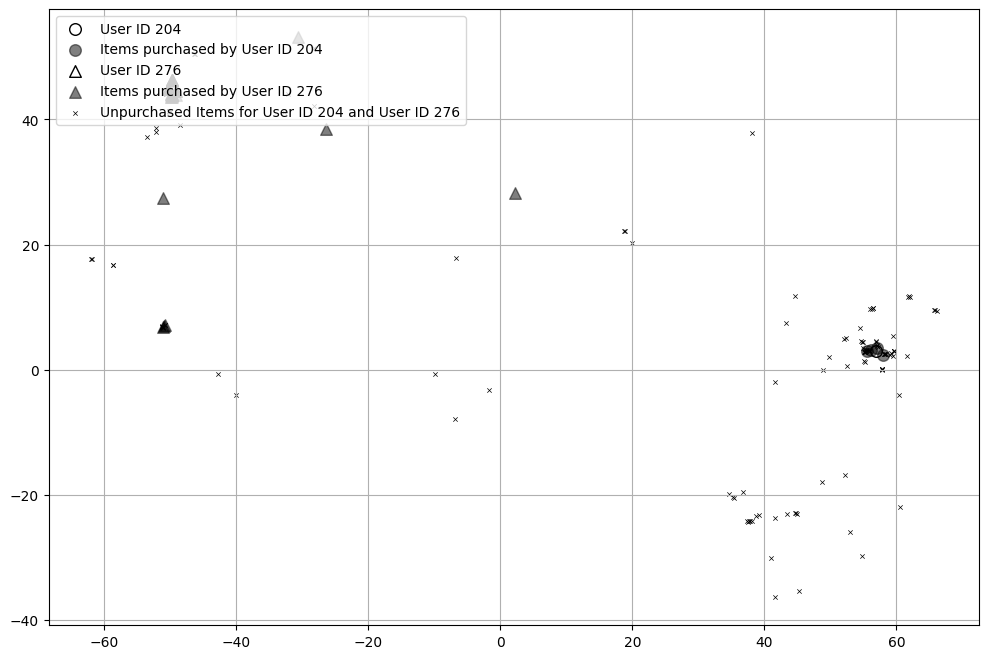

In [130]:
tsne_plot_for_users_label(204, 276, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID5015の推薦数：100
内、過去に購入したアイテム数：51
内、過去に購入していないアイテム数：49
ユーザID10608の推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


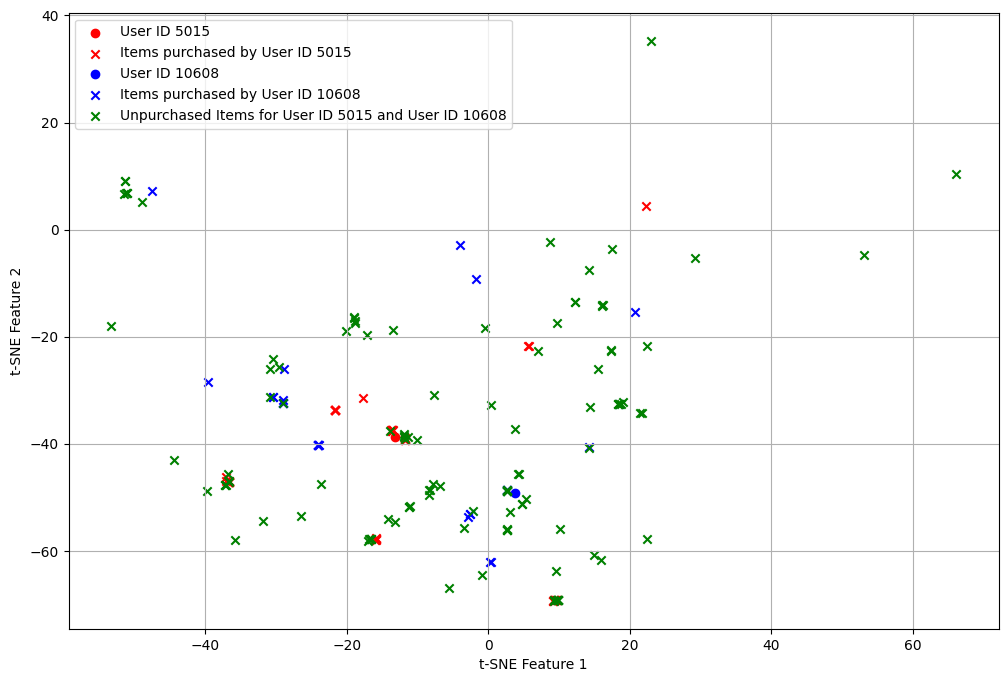

In [257]:
tsne_plot_for_users(5015, 10608, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

ユーザID5015の推薦数：100
内、過去に購入したアイテム数：51
内、過去に購入していないアイテム数：49
ユーザID10608の推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


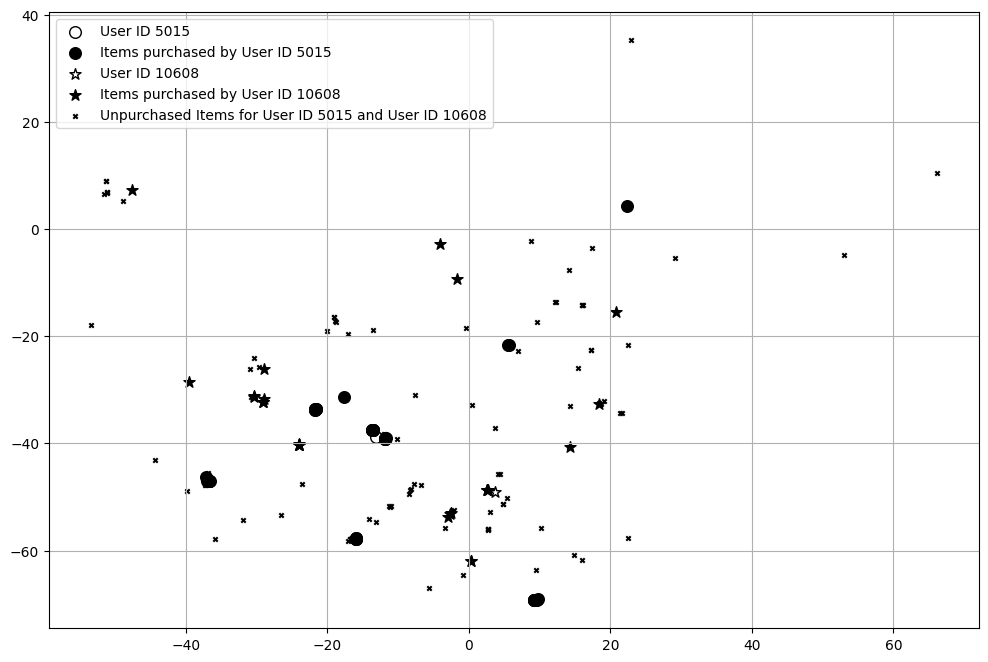

In [58]:
tsne_plot_for_users_notlabel(5015, 10608, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

推薦数：100
内、過去に購入したアイテム数：51
内、過去に購入していないアイテム数：49


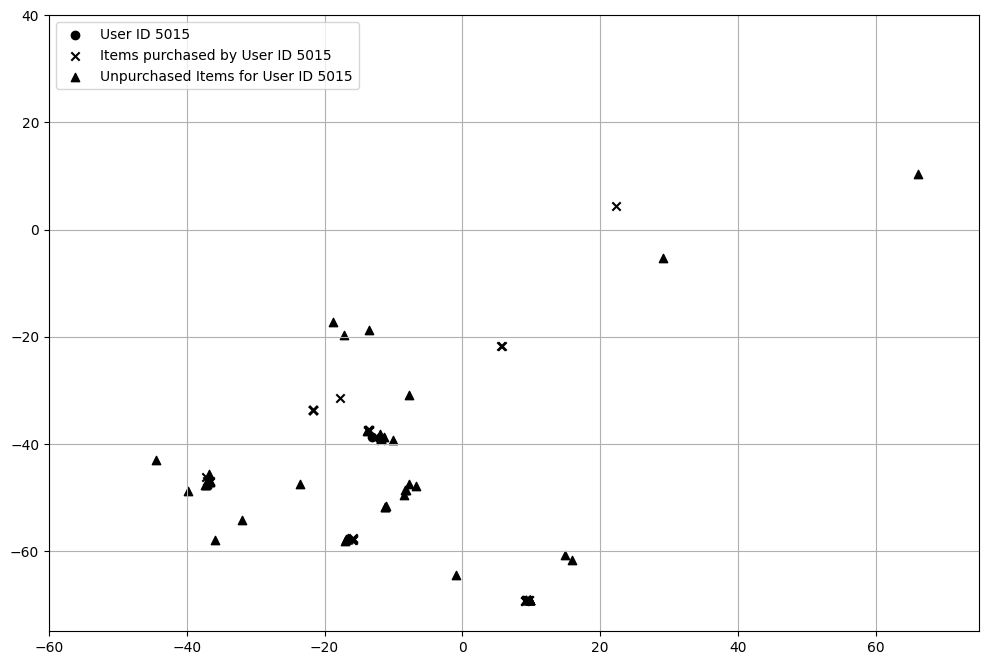

In [112]:
tsne_plot_for_user(5015, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

推薦数：100
内、過去に購入したアイテム数：29
内、過去に購入していないアイテム数：71


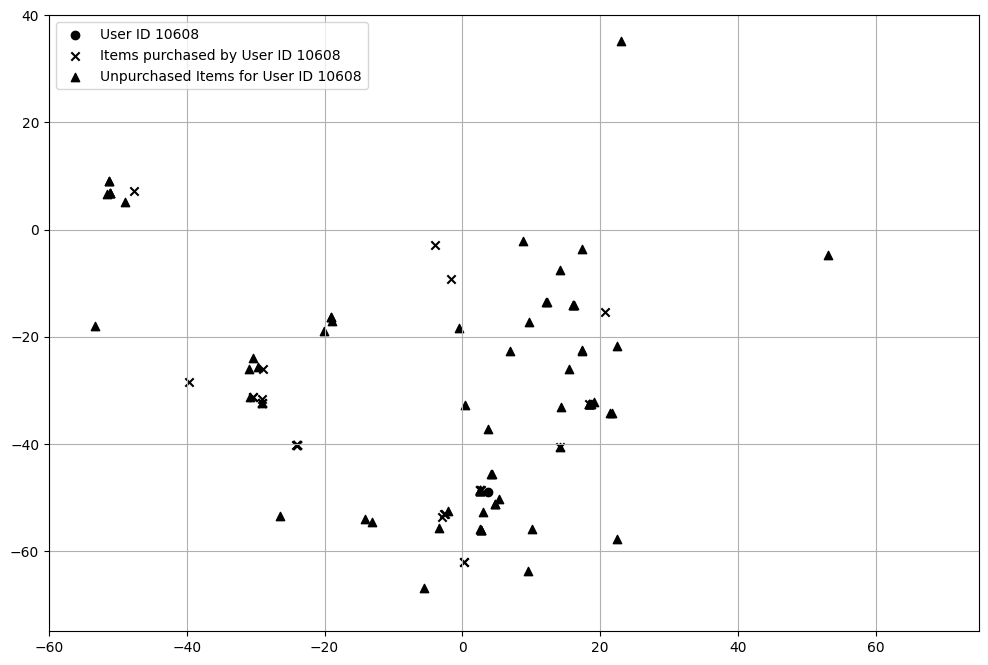

In [113]:
tsne_plot_for_user(10608, all_user_embedding_2d, all_item_embedding_2d, user_items, 100)

# 2番図示

In [130]:
# Filtering the data to find user IDs where the average rank is between 0 and 500,
# and the average attention (User Item Mean) is between 8.5 and 9.
filtered_user_ids_high_attention = [
    user_id for user_id in user_average_ranks.keys()
    if 1000 <= user_average_ranks[user_id] <= 2000
    and user_id in d_user_item_mean
    and 4 <= d_user_item_mean[user_id] <= 5
]

# Displaying the first 10 IDs and the total number of filtered IDs
filtered_user_ids_high_attention[:10], len(filtered_user_ids_high_attention)

([32, 40, 44, 59, 80, 98, 129, 180, 232, 280], 113)

  0%|          | 0/10 [00:00<?, ?it/s]

推薦数：20
内、過去に購入したアイテム数：7
内、過去に購入していないアイテム数：13


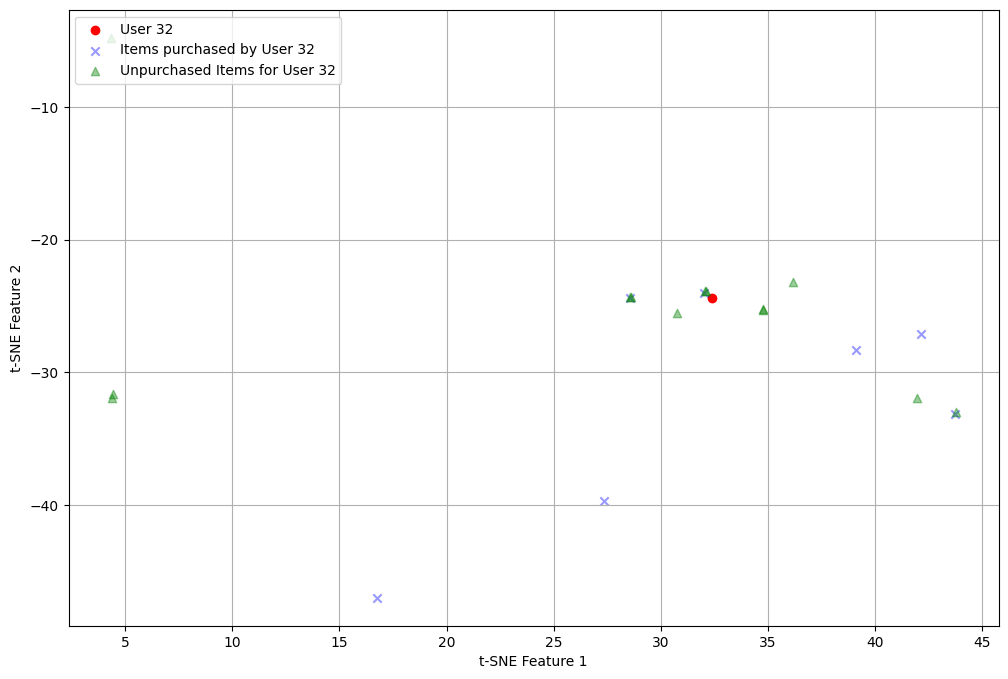

推薦数：20
内、過去に購入したアイテム数：19
内、過去に購入していないアイテム数：1


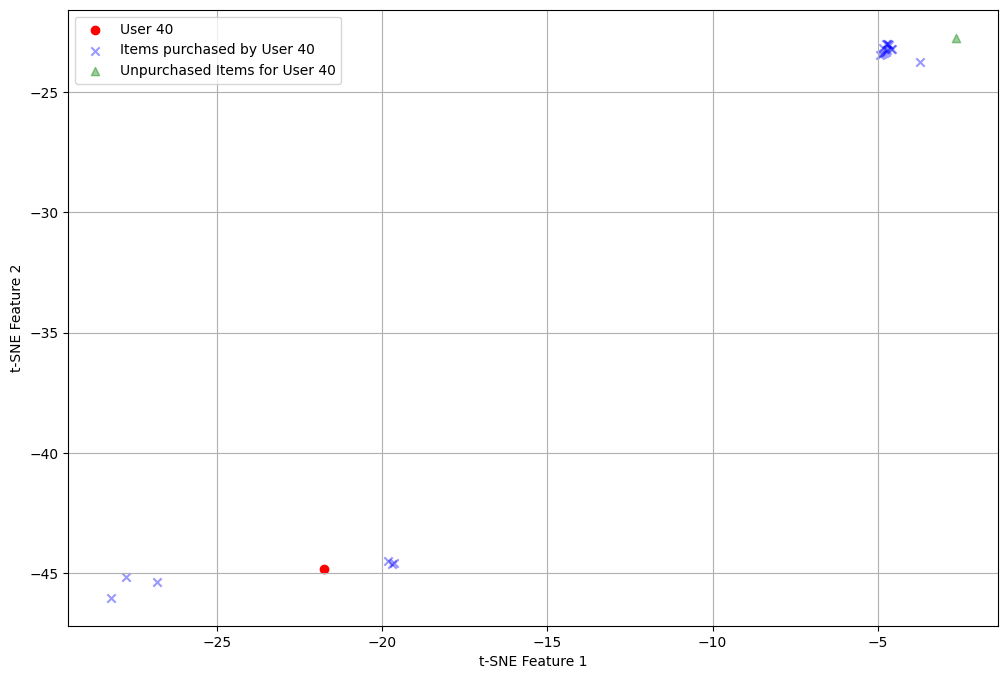

 20%|██        | 2/10 [00:00<00:00, 12.94it/s]

推薦数：20
内、過去に購入したアイテム数：12
内、過去に購入していないアイテム数：8


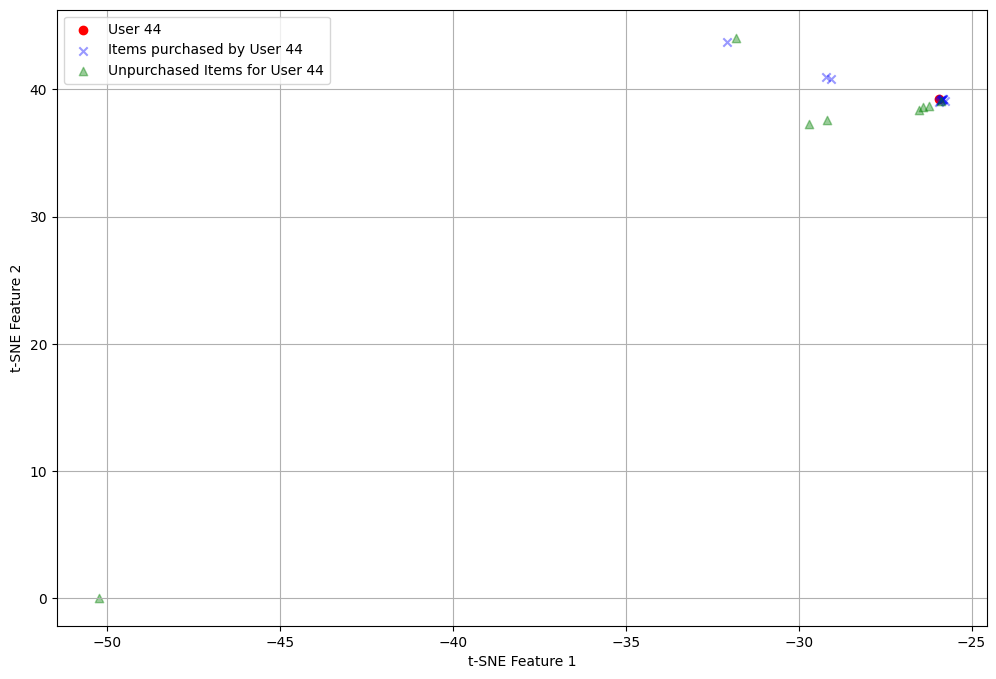

推薦数：20
内、過去に購入したアイテム数：11
内、過去に購入していないアイテム数：9


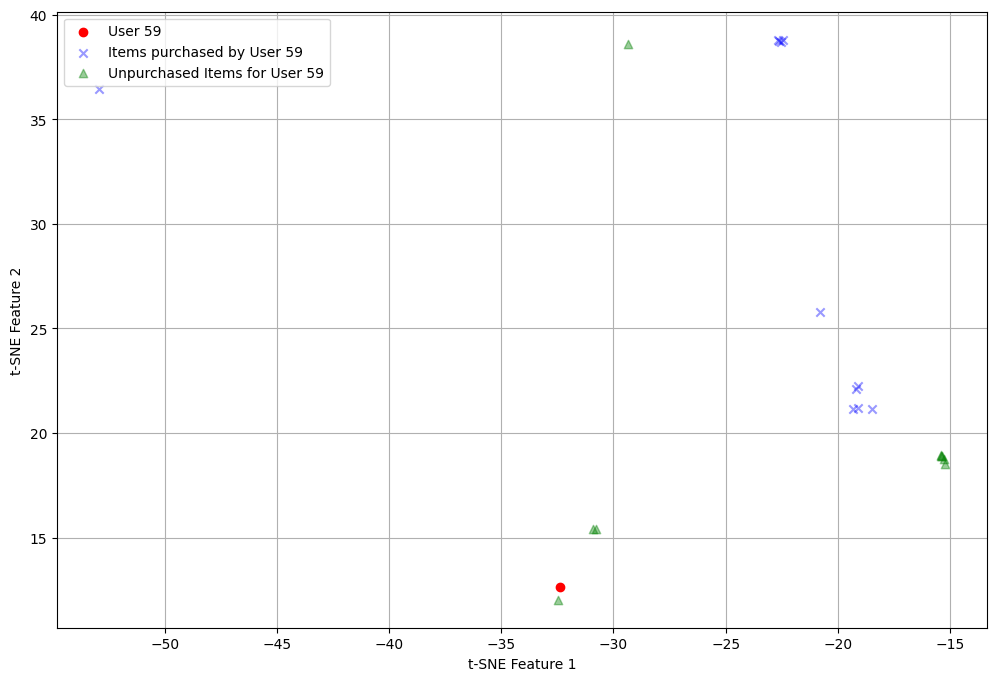

 40%|████      | 4/10 [00:00<00:00, 12.25it/s]

推薦数：20
内、過去に購入したアイテム数：2
内、過去に購入していないアイテム数：18


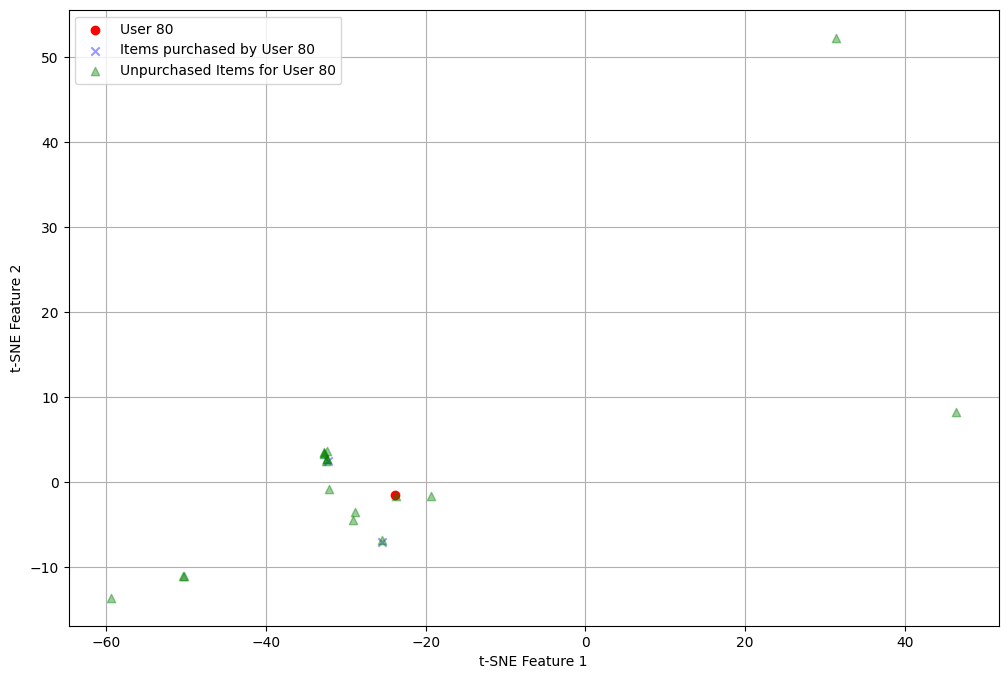

推薦数：20
内、過去に購入したアイテム数：16
内、過去に購入していないアイテム数：4


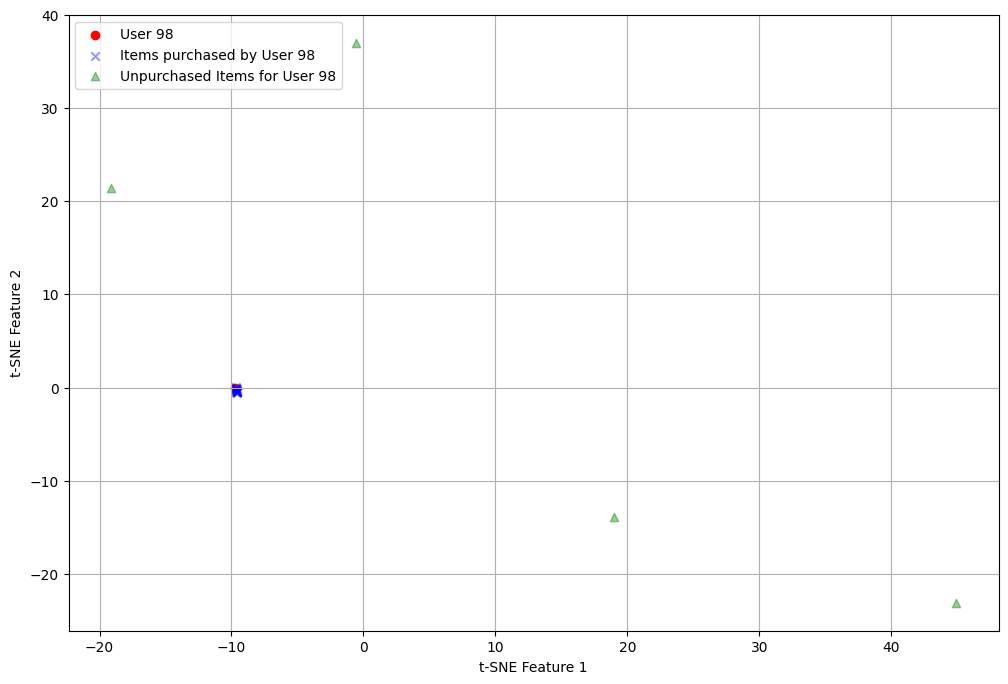

 60%|██████    | 6/10 [00:00<00:00, 12.16it/s]

推薦数：20
内、過去に購入したアイテム数：9
内、過去に購入していないアイテム数：11


 60%|██████    | 6/10 [00:28<00:00, 12.16it/s]

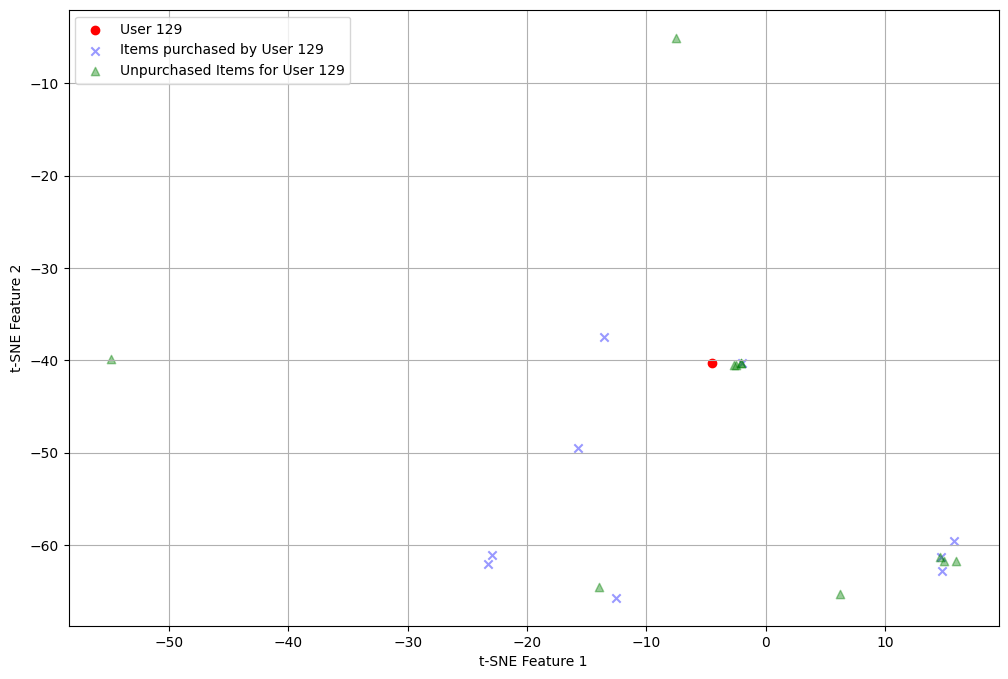

 70%|███████   | 7/10 [00:28<00:20,  6.96s/it]

推薦数：20
内、過去に購入したアイテム数：6
内、過去に購入していないアイテム数：14


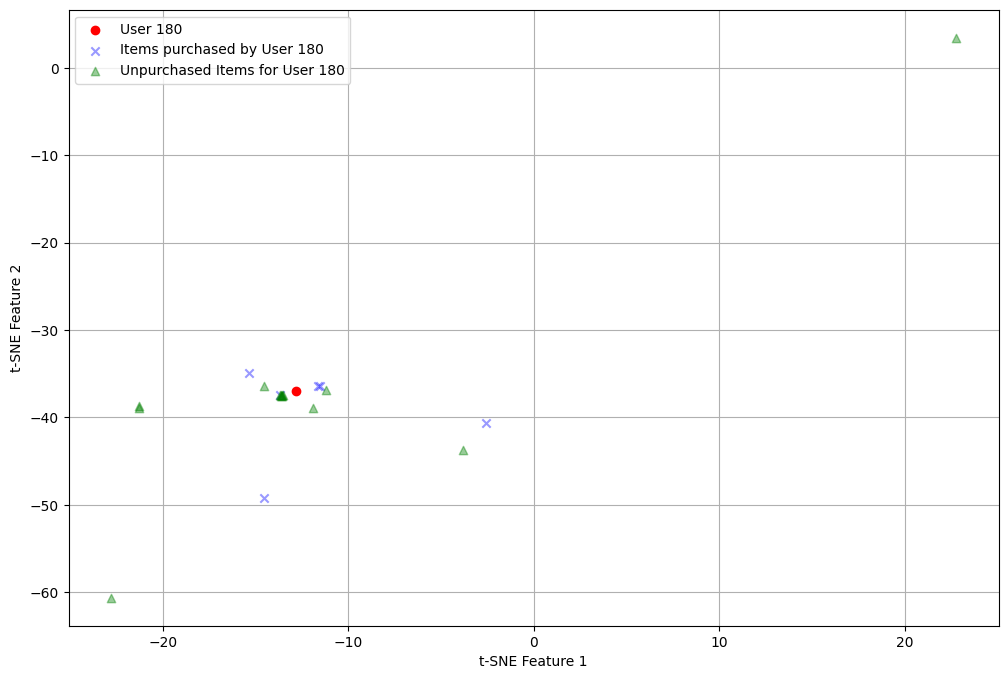

推薦数：20
内、過去に購入したアイテム数：1
内、過去に購入していないアイテム数：19


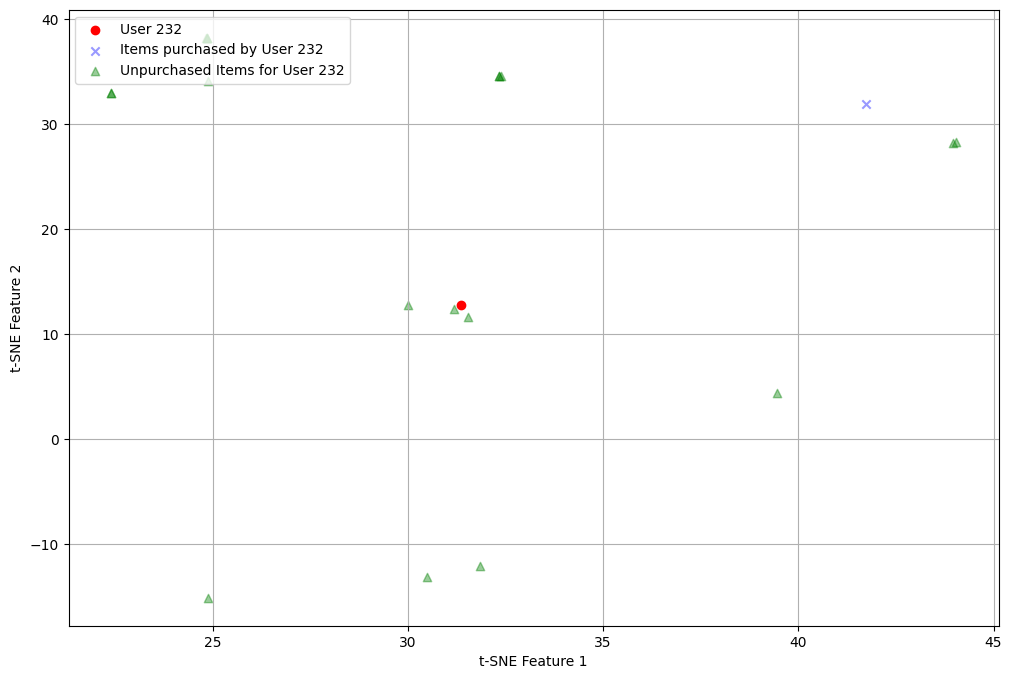

 90%|█████████ | 9/10 [00:28<00:04,  4.12s/it]

推薦数：20
内、過去に購入したアイテム数：10
内、過去に購入していないアイテム数：10


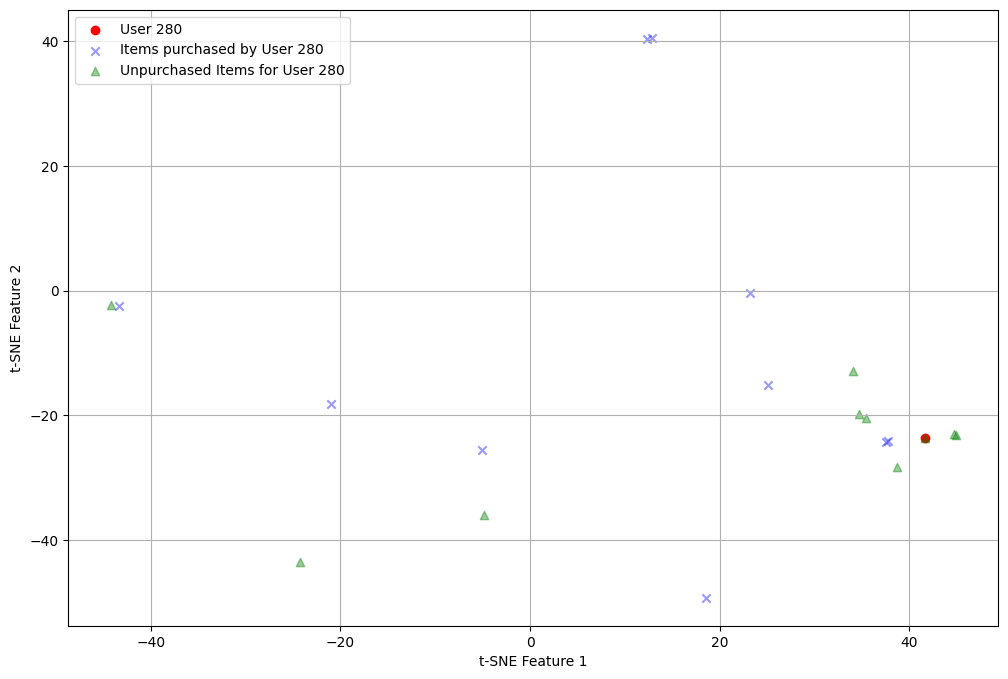

100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


In [170]:
# Selected user IDs from the previous query
selected_user_ids = [32, 40, 44, 59, 80, 98, 129, 180, 232, 280]

# Apply the function to each selected user
for user_id in tqdm(selected_user_ids):
    tsne_plot_for_user(user_id, all_user_embedding_2d, all_item_embedding_2d, user_items, 20)

未購入アイテム数平均10.7

# 1番図示

In [168]:
# Filtering the data to find user IDs where the average rank is between 0 and 500,
# and the average attention (User Item Mean) is between 8.5 and 9.
filtered_user_ids_high_attention = [
    user_id for user_id in user_average_ranks.keys()
    if 0 <= user_average_ranks[user_id] <= 1000
    and user_id in d_user_item_mean
    and 4 <= d_user_item_mean[user_id] <= 5
]

# Displaying the first 10 IDs and the total number of filtered IDs
filtered_user_ids_high_attention[:10], len(filtered_user_ids_high_attention)

([39, 145, 156, 166, 173, 174, 225, 247, 275, 289], 340)

  0%|          | 0/10 [00:00<?, ?it/s]

推薦数：20
内、過去に購入したアイテム数：10
内、過去に購入していないアイテム数：10


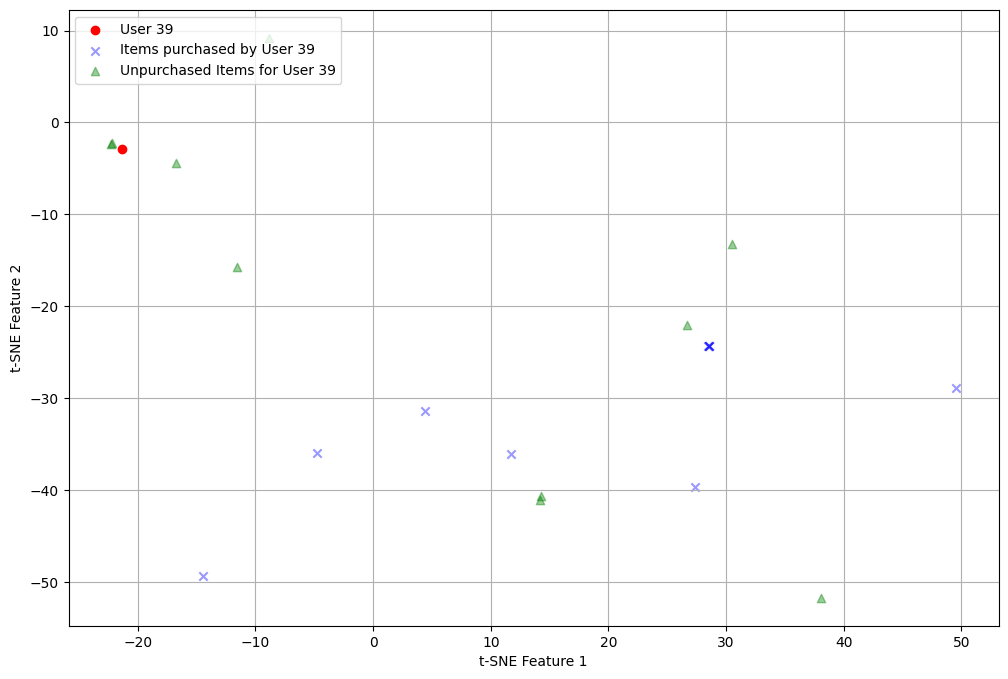

推薦数：20
内、過去に購入したアイテム数：12
内、過去に購入していないアイテム数：8


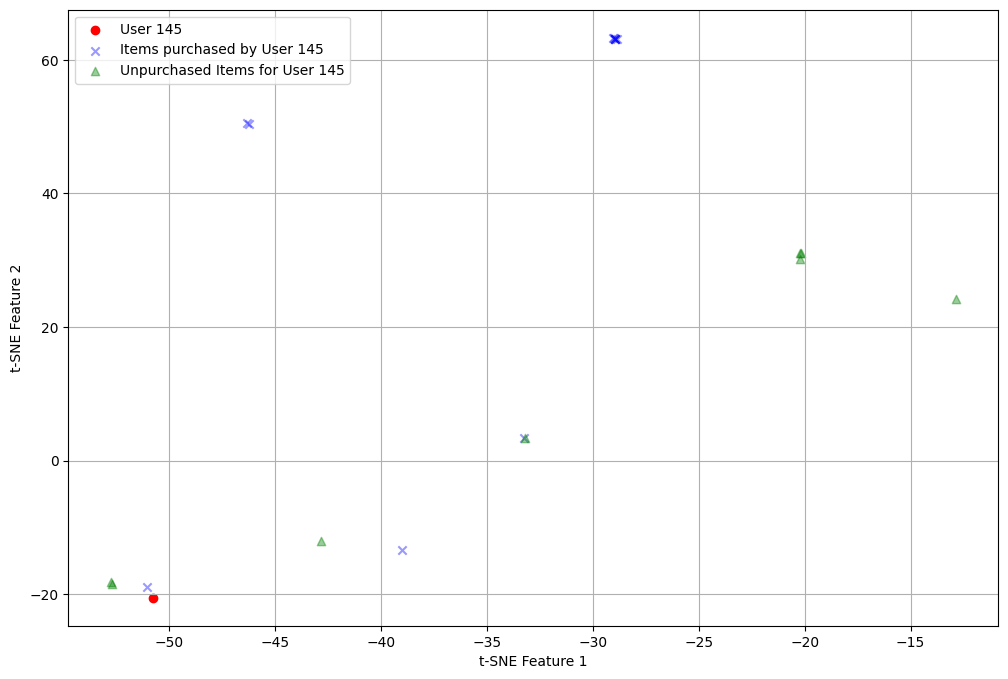

 20%|██        | 2/10 [00:00<00:00, 11.79it/s]

推薦数：20
内、過去に購入したアイテム数：7
内、過去に購入していないアイテム数：13


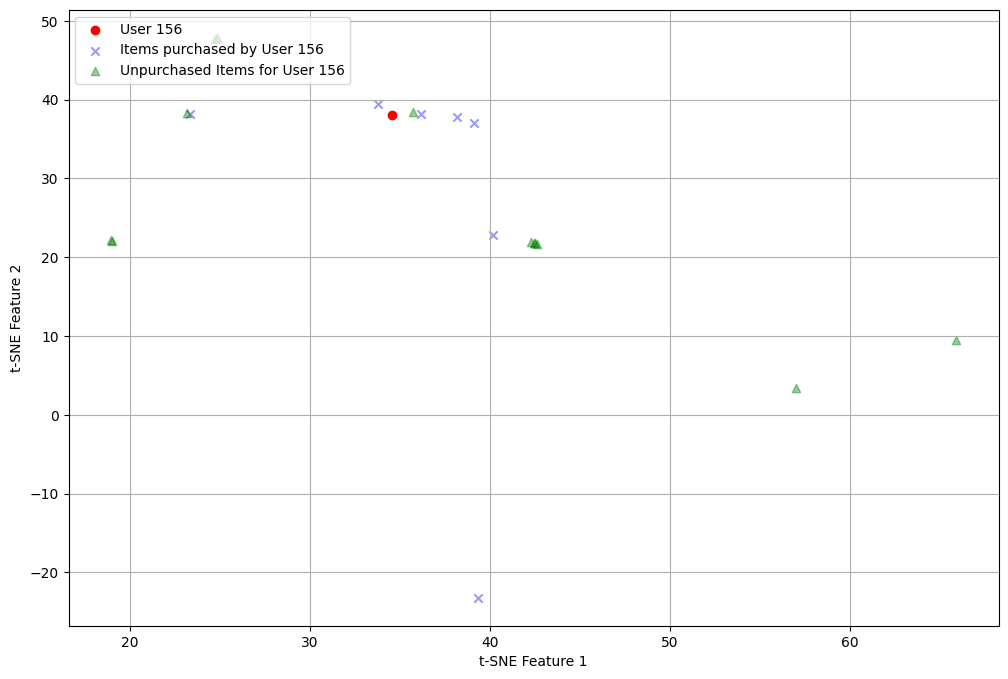

推薦数：20
内、過去に購入したアイテム数：8
内、過去に購入していないアイテム数：12


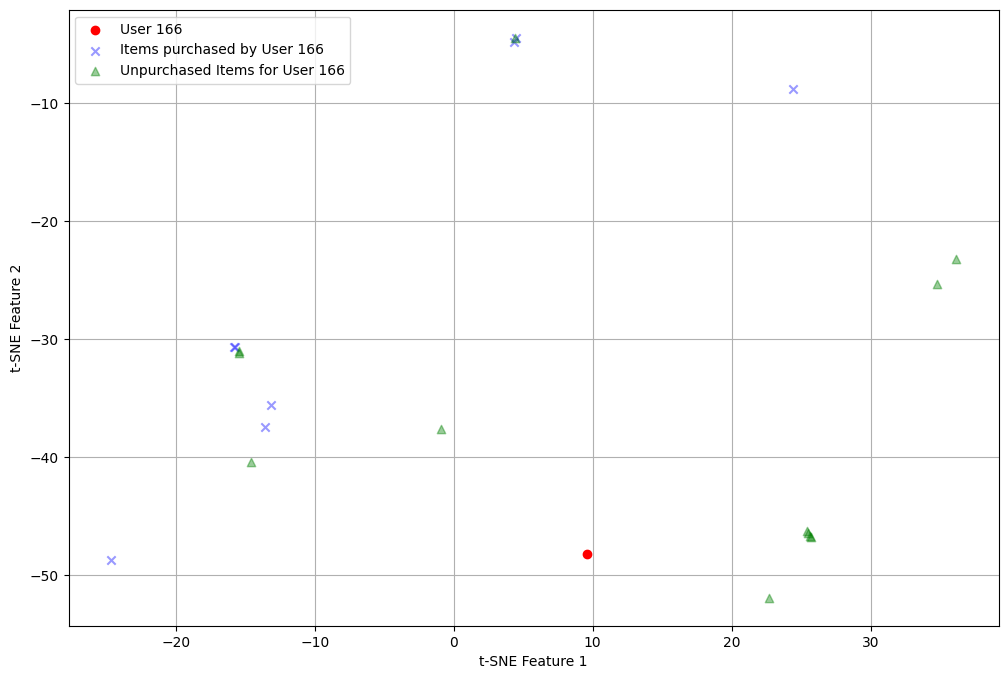

 40%|████      | 4/10 [00:00<00:00, 12.04it/s]

推薦数：20
内、過去に購入したアイテム数：9
内、過去に購入していないアイテム数：11


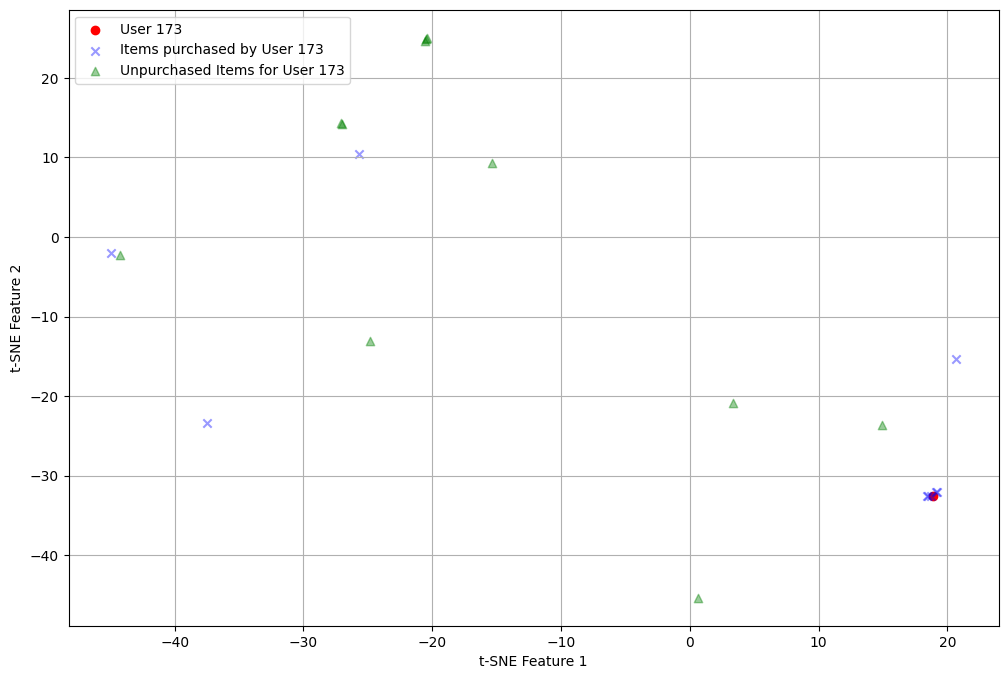

推薦数：20
内、過去に購入したアイテム数：16
内、過去に購入していないアイテム数：4


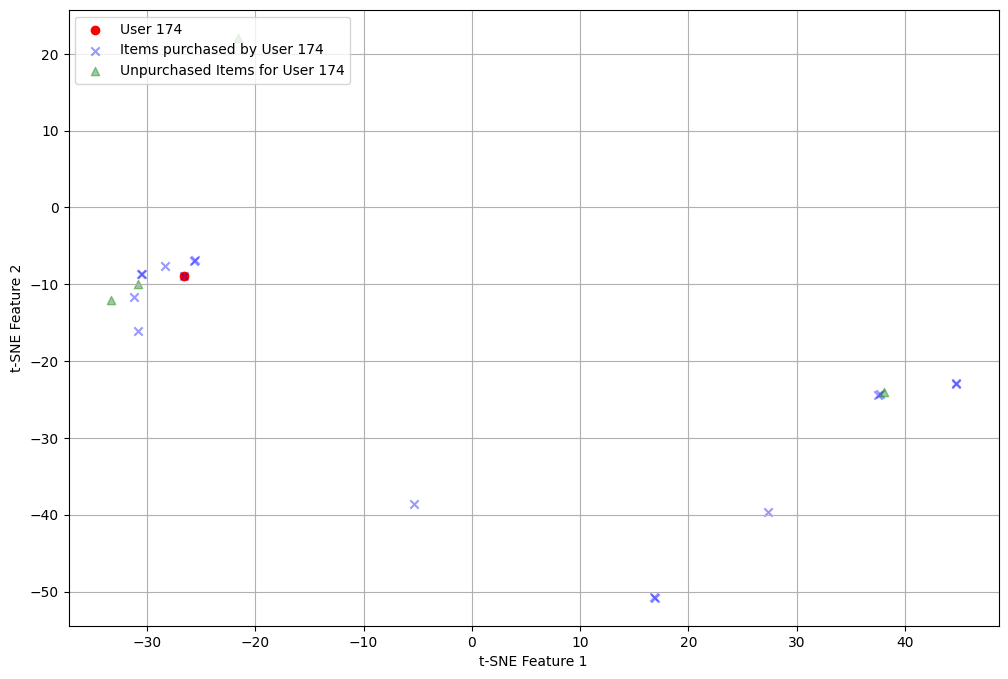

 60%|██████    | 6/10 [00:00<00:00, 11.64it/s]

推薦数：20
内、過去に購入したアイテム数：7
内、過去に購入していないアイテム数：13


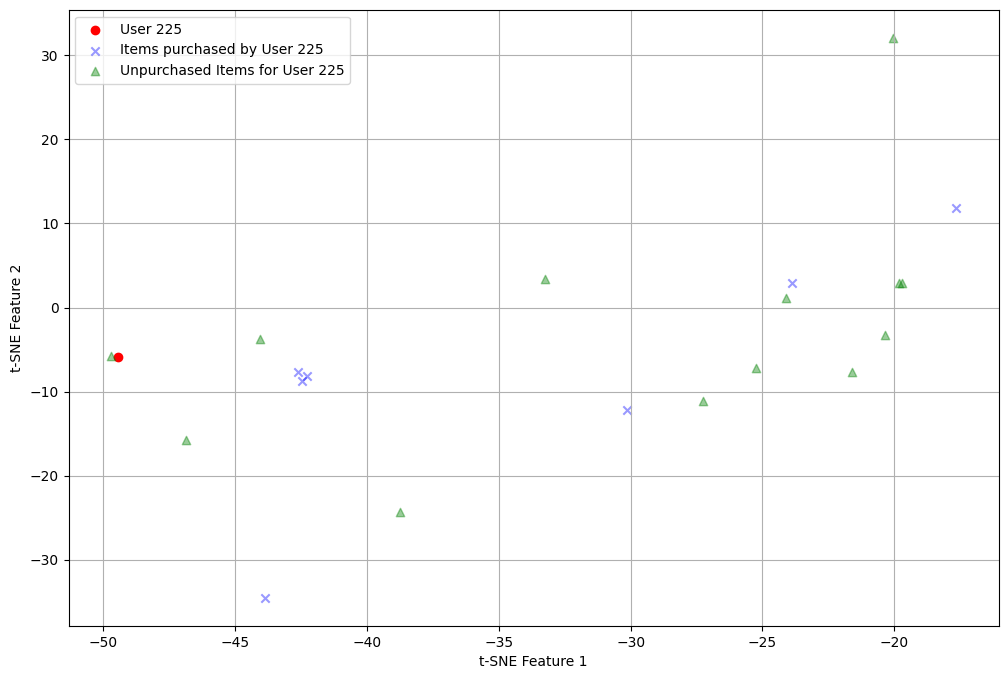

推薦数：20
内、過去に購入したアイテム数：12
内、過去に購入していないアイテム数：8


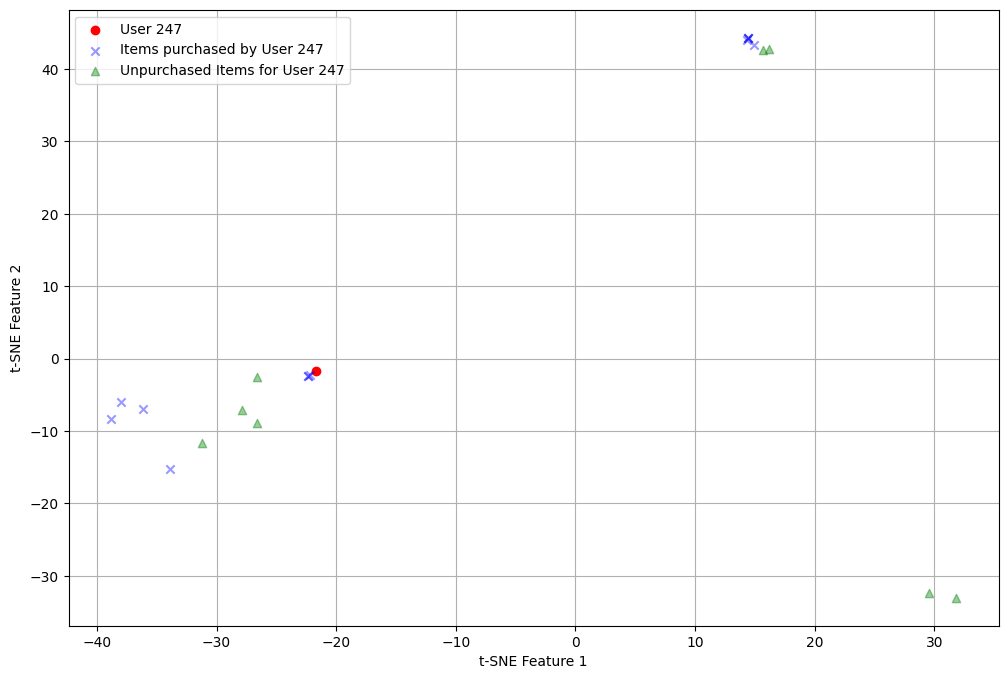

 80%|████████  | 8/10 [00:00<00:00, 11.69it/s]

推薦数：20
内、過去に購入したアイテム数：11
内、過去に購入していないアイテム数：9


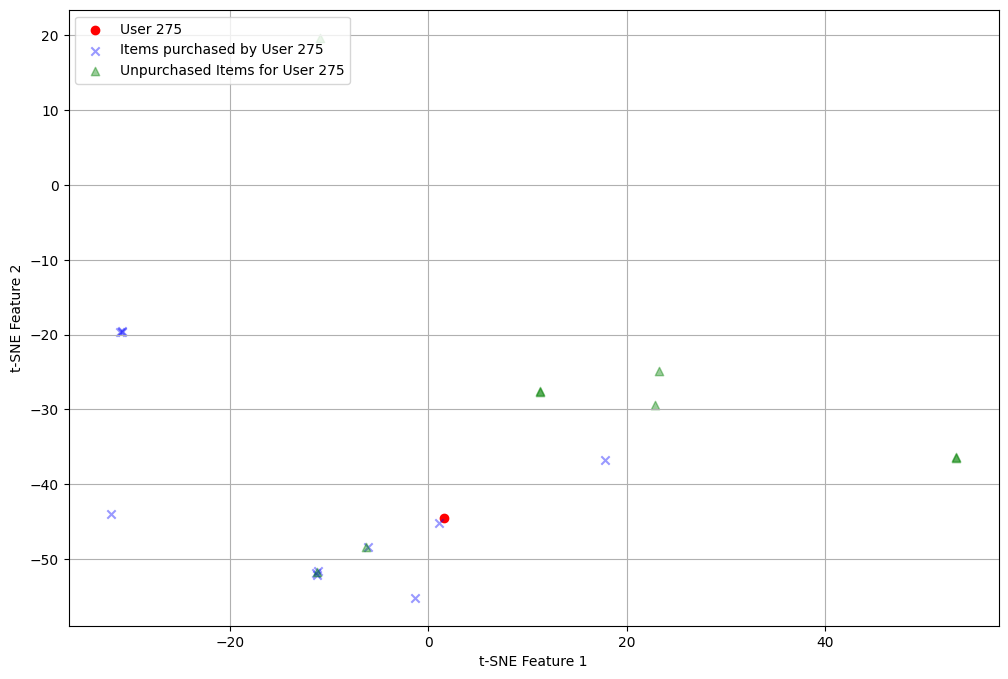

推薦数：20
内、過去に購入したアイテム数：8
内、過去に購入していないアイテム数：12


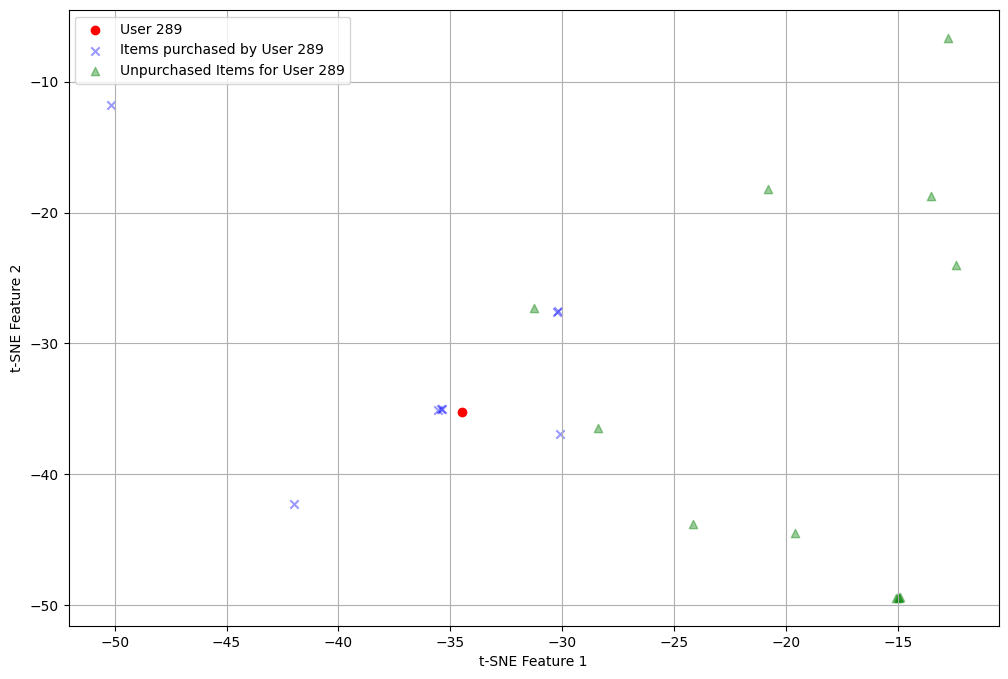

100%|██████████| 10/10 [00:00<00:00, 11.77it/s]


In [171]:
# Selected user IDs from the previous query
selected_user_ids = [39, 145, 156, 166, 173, 174, 225, 247, 275, 289]
# Apply the function to each selected user
for user_id in tqdm(selected_user_ids):
    tsne_plot_for_user(user_id, all_user_embedding_2d, all_item_embedding_2d, user_items, 20)

未購入アイテム数平均10.0

# 3番図示

In [118]:
# Filtering the data to find user IDs where the average rank is between 0 and 500,
# and the average attention (User Item Mean) is between 8.5 and 9.
filtered_user_ids_high_attention = [
    user_id for user_id in user_average_ranks.keys()
    if 0 <= user_average_ranks[user_id] <= 1000
    and user_id in d_user_item_mean
    and 7 <= d_user_item_mean[user_id] <= 8
]

# Displaying the first 10 IDs and the total number of filtered IDs
filtered_user_ids_high_attention[:10], len(filtered_user_ids_high_attention)


([3, 9, 12, 13, 14, 24, 33, 35, 41, 42], 9960)

  0%|          | 0/10 [00:00<?, ?it/s]

推薦数：20
内、過去に購入したアイテム数：12
内、過去に購入していないアイテム数：8


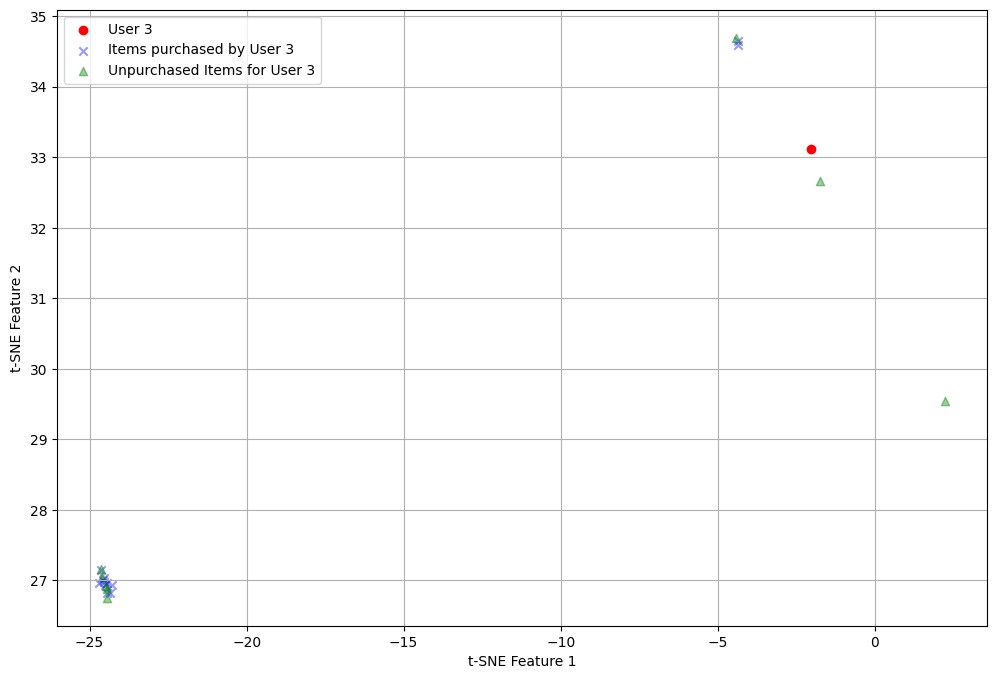

推薦数：20
内、過去に購入したアイテム数：11
内、過去に購入していないアイテム数：9


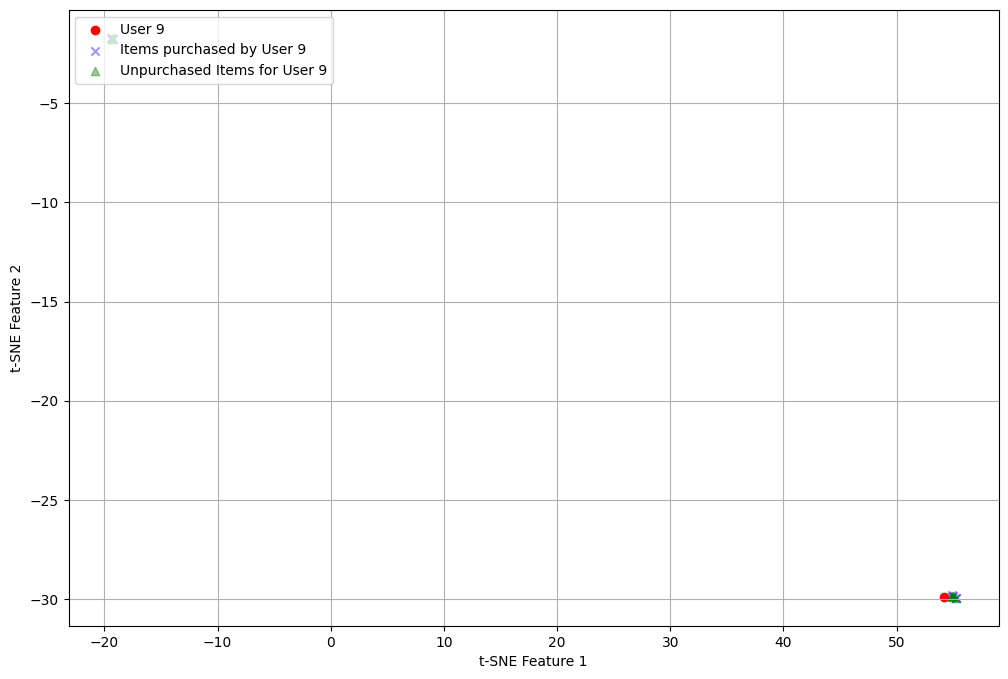

 20%|██        | 2/10 [00:00<00:00, 12.10it/s]

推薦数：20
内、過去に購入したアイテム数：14
内、過去に購入していないアイテム数：6


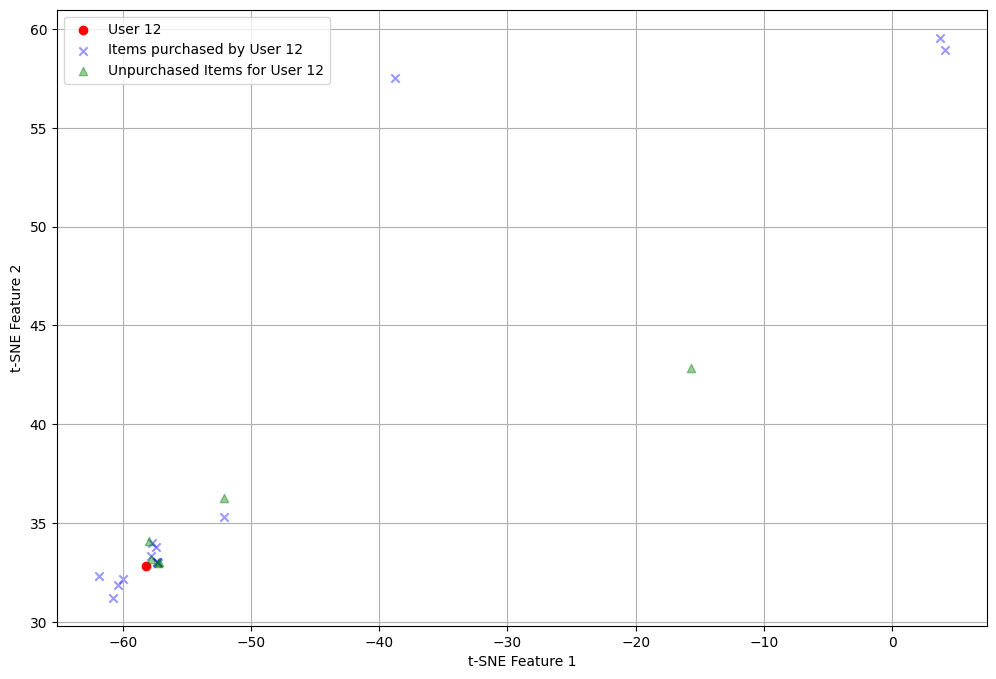

推薦数：20
内、過去に購入したアイテム数：9
内、過去に購入していないアイテム数：11


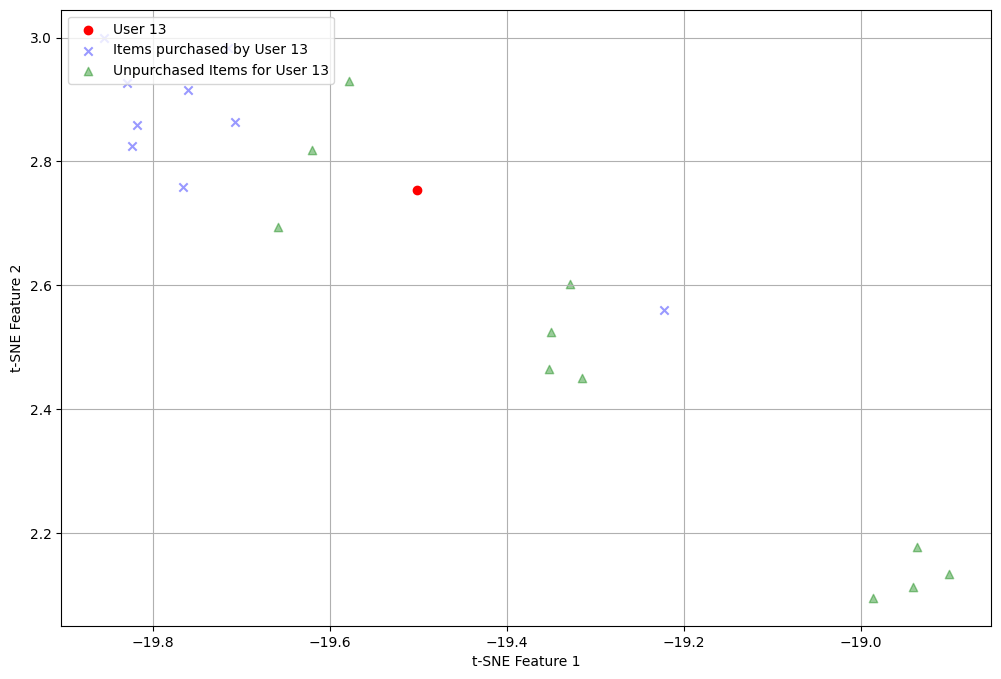

 40%|████      | 4/10 [00:00<00:00, 12.69it/s]

推薦数：20
内、過去に購入したアイテム数：15
内、過去に購入していないアイテム数：5


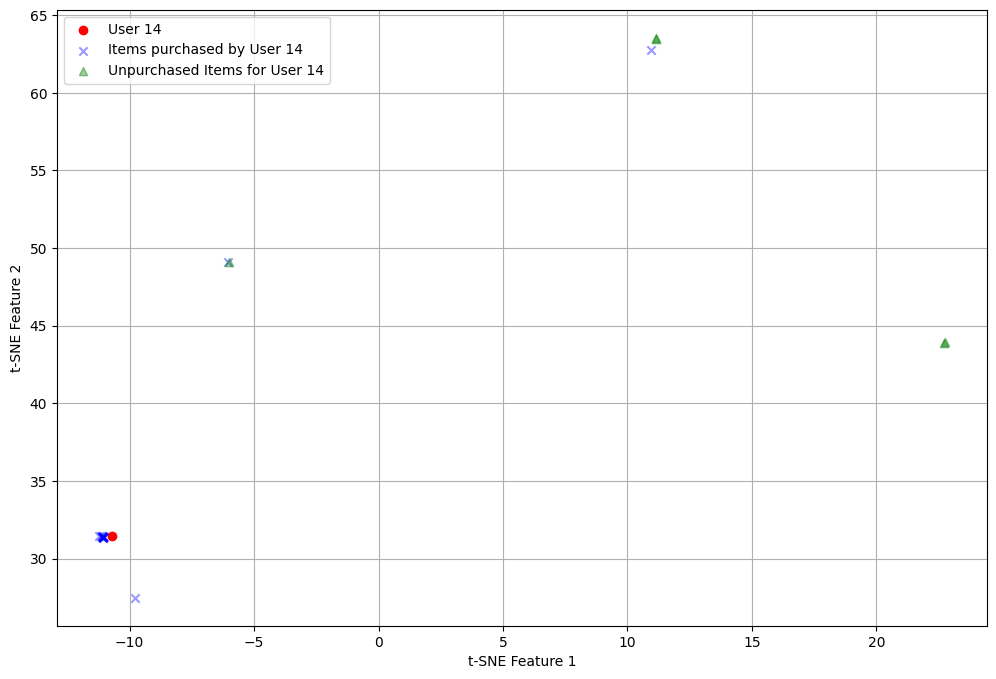

推薦数：20
内、過去に購入したアイテム数：8
内、過去に購入していないアイテム数：12


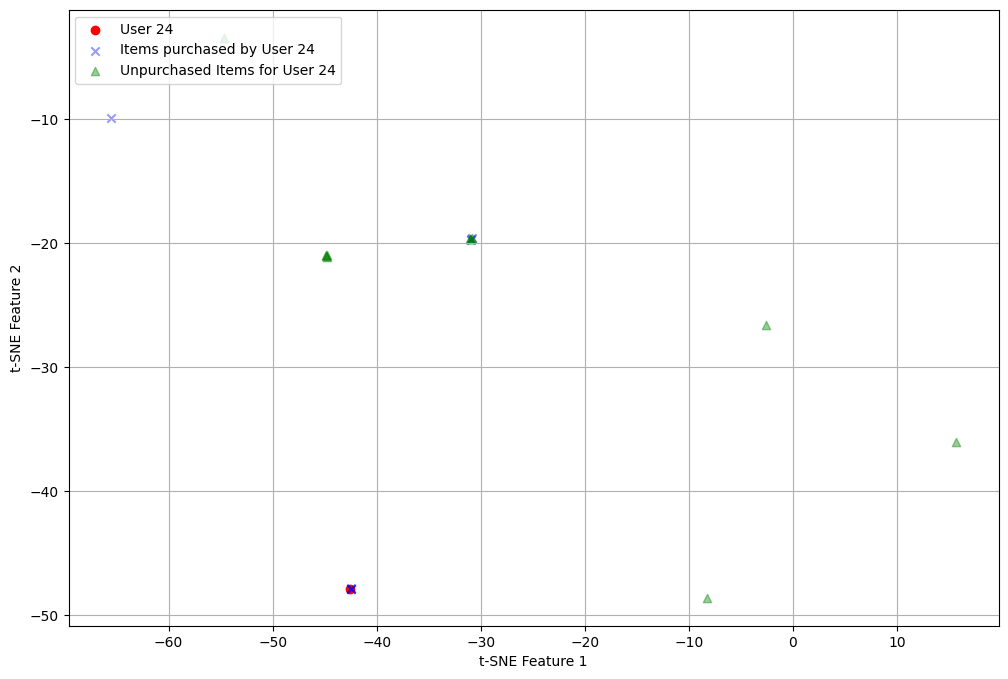

 60%|██████    | 6/10 [00:00<00:00, 12.44it/s]

推薦数：20
内、過去に購入したアイテム数：9
内、過去に購入していないアイテム数：11


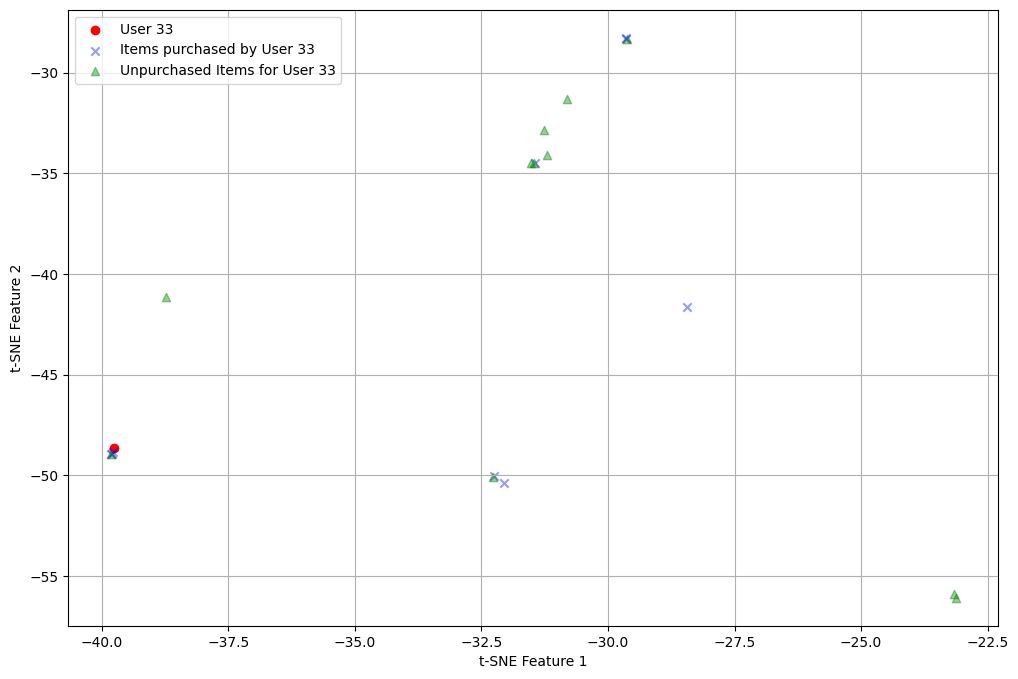

推薦数：20
内、過去に購入したアイテム数：19
内、過去に購入していないアイテム数：1


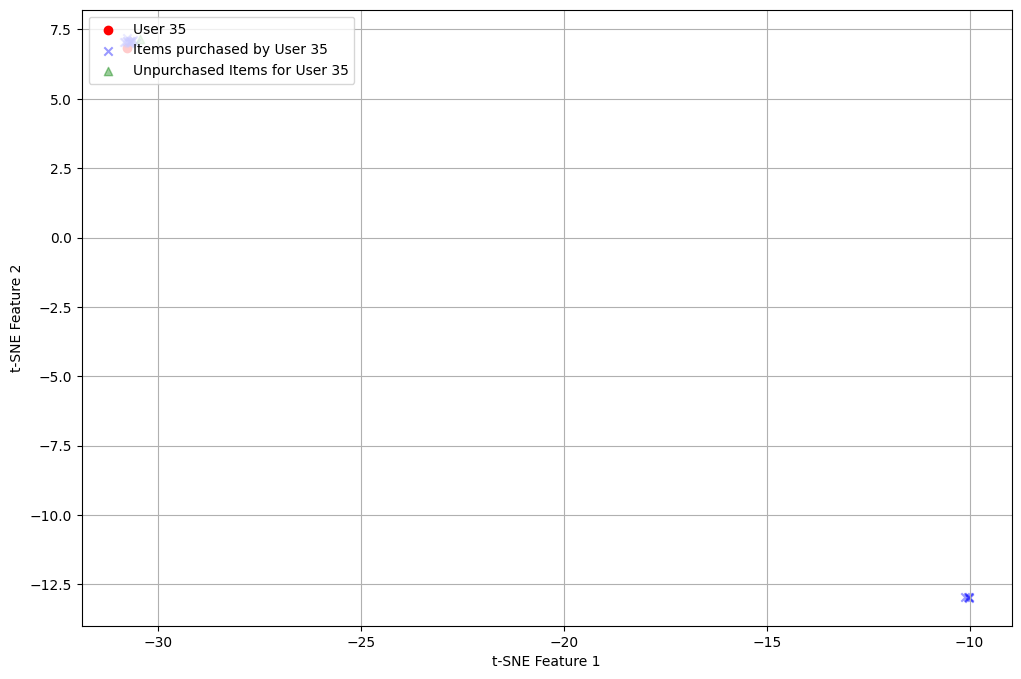

 80%|████████  | 8/10 [00:00<00:00, 12.26it/s]

推薦数：20
内、過去に購入したアイテム数：15
内、過去に購入していないアイテム数：5


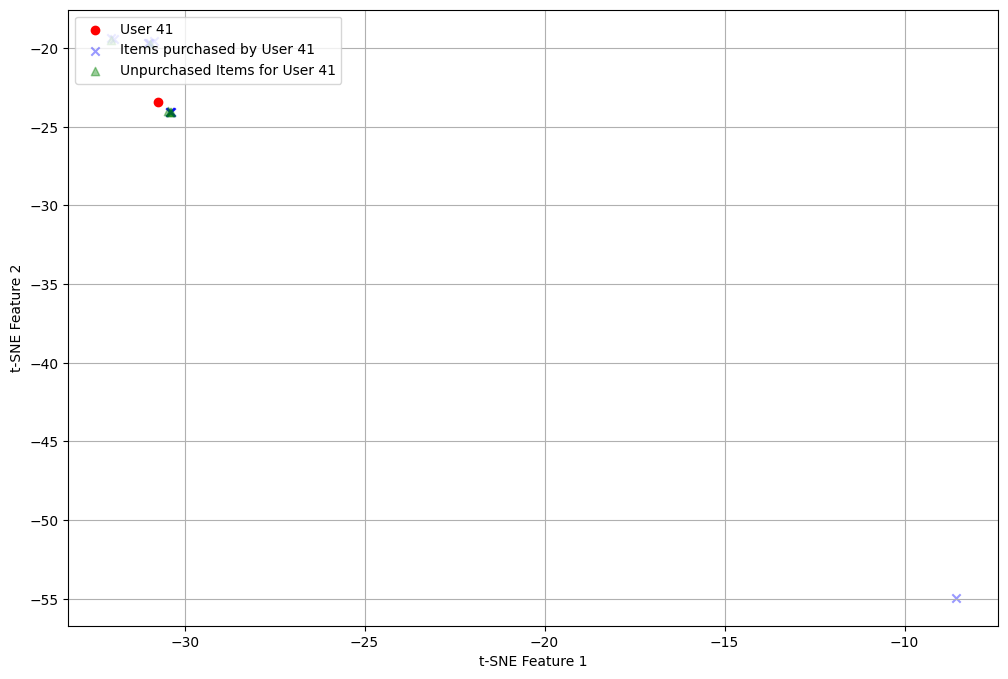

推薦数：20
内、過去に購入したアイテム数：19
内、過去に購入していないアイテム数：1


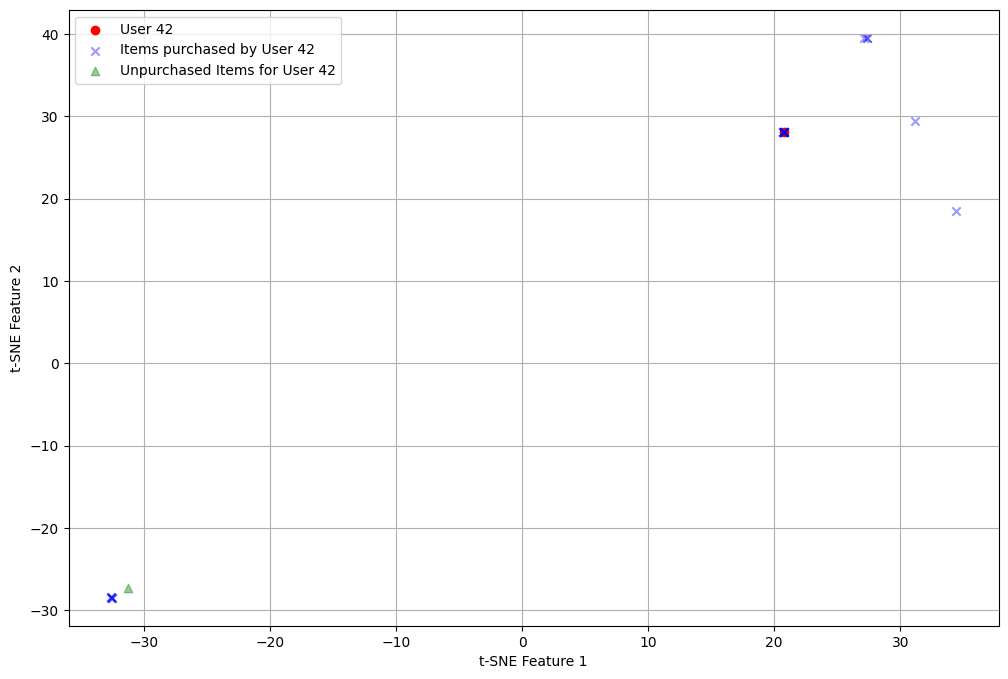

100%|██████████| 10/10 [00:00<00:00, 12.07it/s]


In [172]:
# Selected user IDs from the previous query
selected_user_ids = [3, 9, 12, 13, 14, 24, 33, 35, 41, 42]

# Apply the function to each selected user
for user_id in tqdm(selected_user_ids):
    tsne_plot_for_user(user_id, all_user_embedding_2d, all_item_embedding_2d, user_items, 20)

# 4番図示

In [92]:
# Filtering the data to find user IDs where the average rank is between 1000 and 2000,
# and the average attention (User Item Mean) is between 7 and 8.

filtered_user_ids_specific_range = [
    user_id for user_id in user_average_ranks.keys()
    if 1000 <= user_average_ranks[user_id] <= 2000
    and user_id in d_user_item_mean
    and 7 <= d_user_item_mean[user_id] <= 8
]

# Assuming there is only one user in this range
filtered_user_id = filtered_user_ids_specific_range[0] if filtered_user_ids_specific_range else None
filtered_user_id


21

  0%|          | 0/1 [00:00<?, ?it/s]

推薦数：20
内、過去に購入したアイテム数：14
内、過去に購入していないアイテム数：6


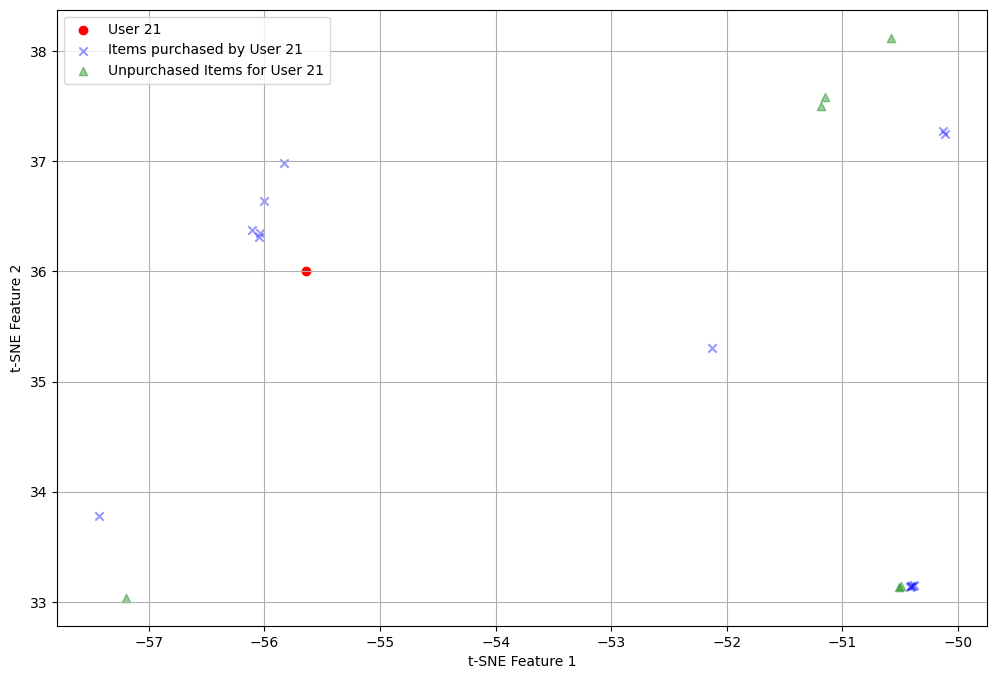

100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


In [174]:
# Selected user IDs from the previous query
selected_user_ids = [21]
# Apply the function to each selected user
for user_id in tqdm(selected_user_ids):
    tsne_plot_for_user(user_id, all_user_embedding_2d, all_item_embedding_2d, user_items, 20)